In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/PRIM/code/src/data')

Mounted at /content/drive


# I. INPUT ANALYSIS

In [ ]:
import sys
from cvat_xml import *
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def count_tracks_by_label(xml, label, role=None, main=None):
    """
    Count the number of tracks of a specific label,
    optionally filtered by role or main attribute.
    """
    if label == 'Person':
        track_class = PersonTrack
    elif label == 'Ball':
        track_class = BallTrack
    elif label == 'Table':
        track_class = TableTrack
    else:
        raise ValueError(f"Unsupported label: {label}")

    query = f"track[@label='{label}']"
    if role:
        query += f"/skeleton/attribute[@name='Role'][.='{role}']/../.."
    if main is not None:
        query += f"/skeleton/attribute[@name='Main'][.='{'true' if main else 'false'}']/../.."
    results = 0
    for track in xml.findall(query):
        obj = track_class.load(track)
        results += obj.last_frame() - obj.start_frame + 1
    return results




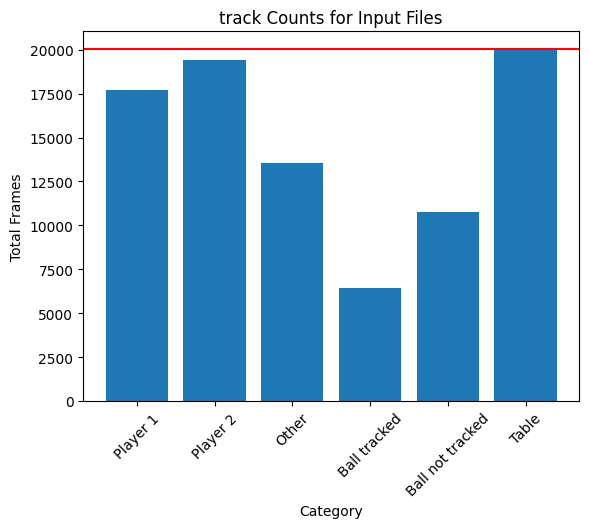

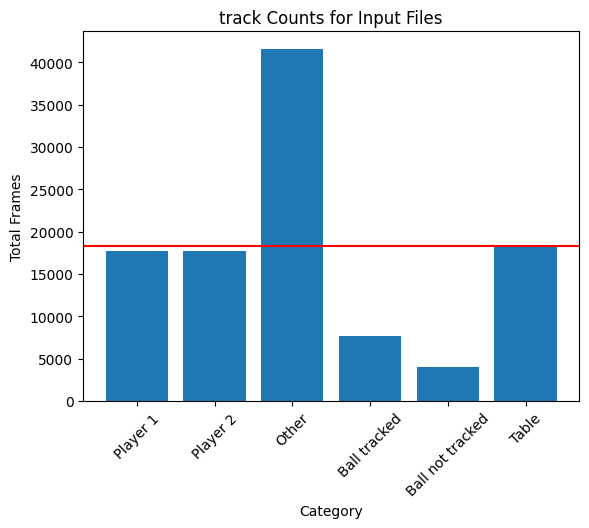

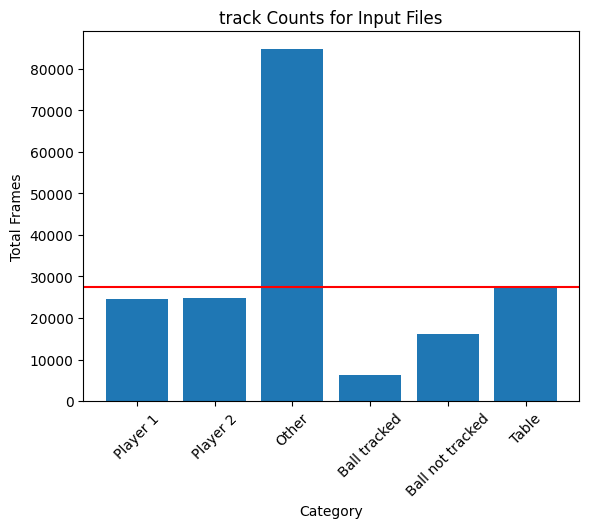

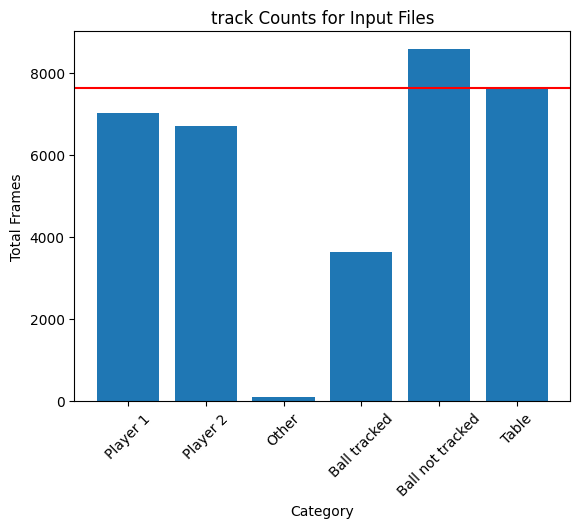

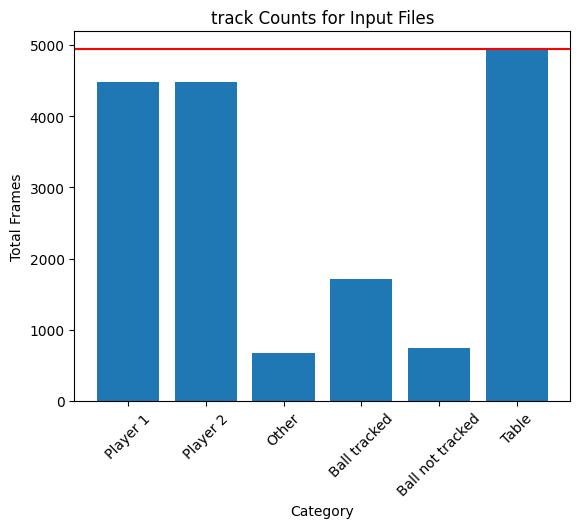

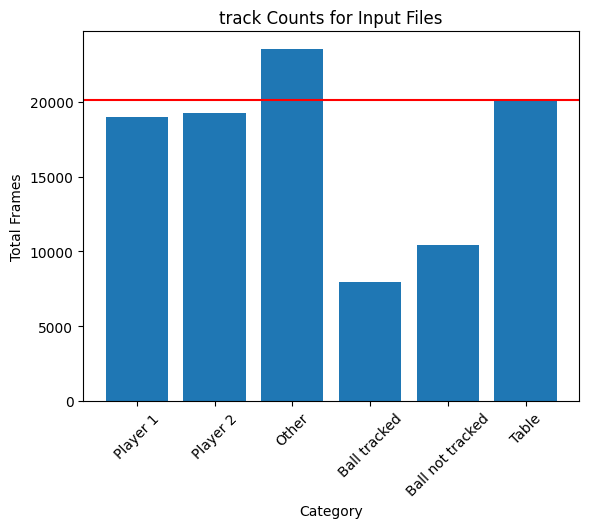

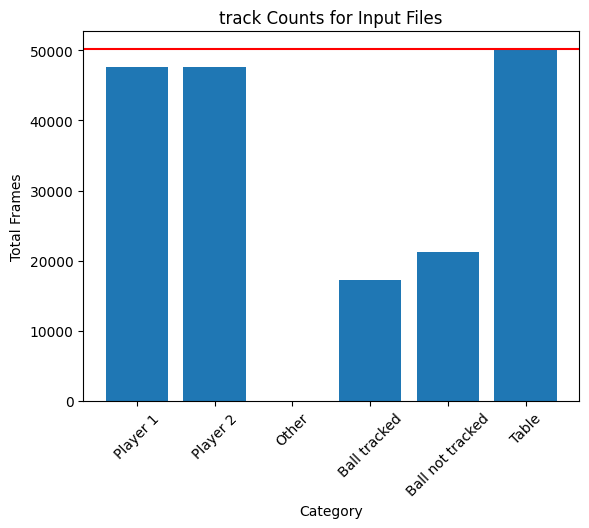

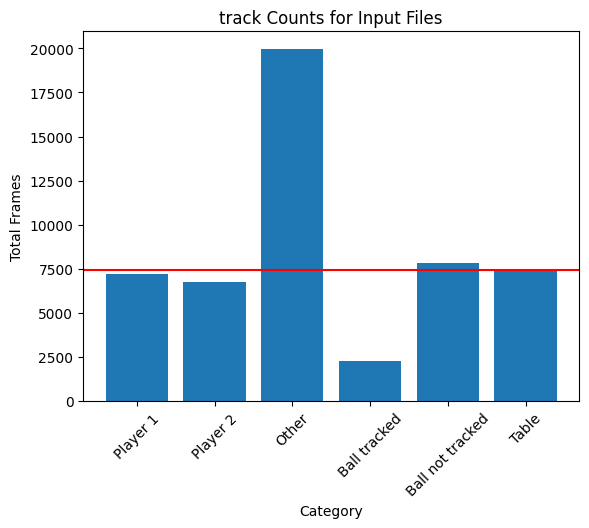

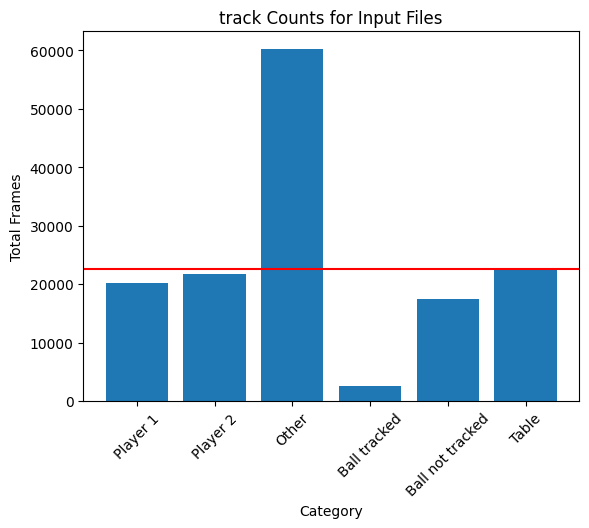

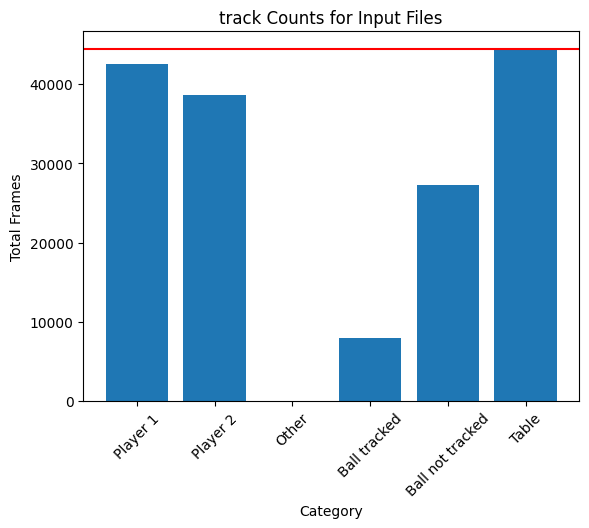

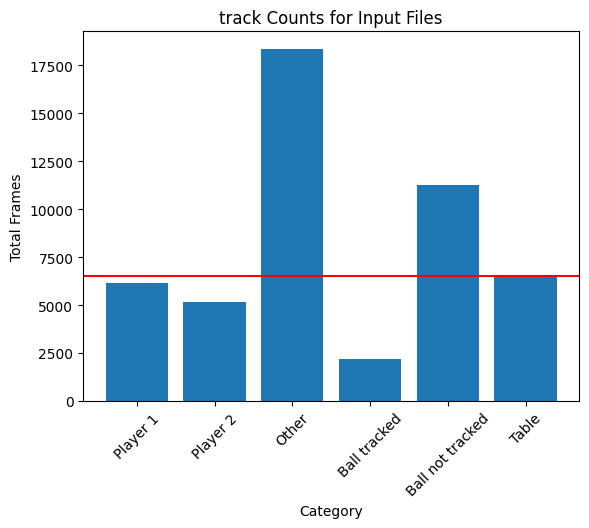

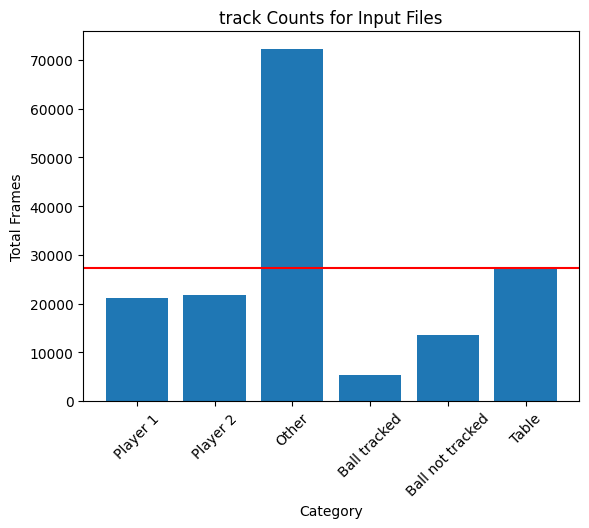

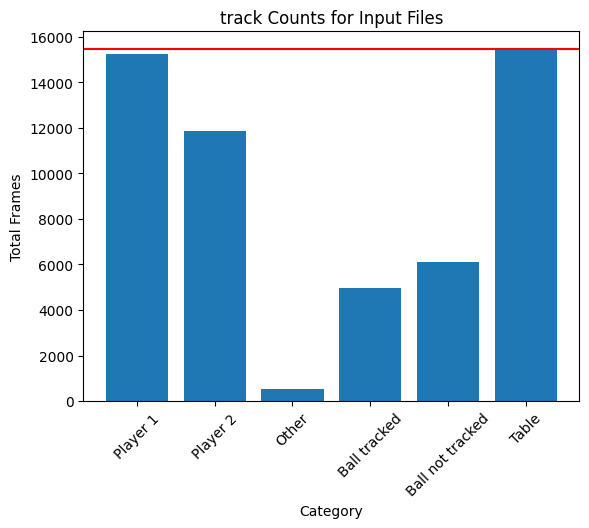

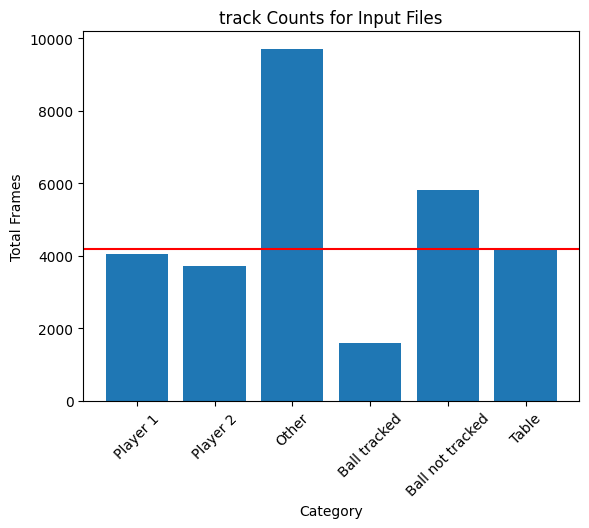

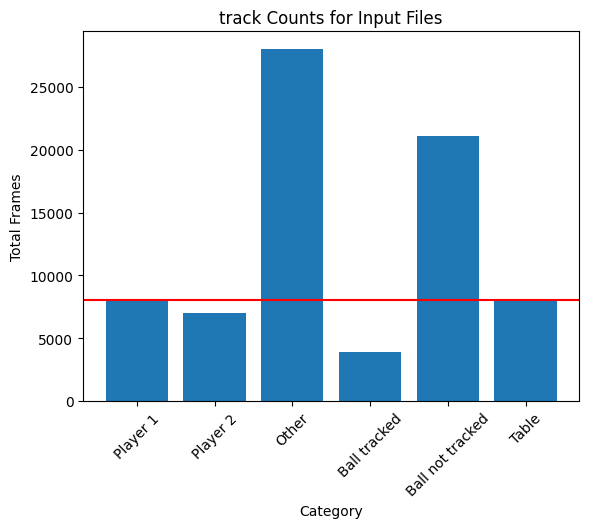

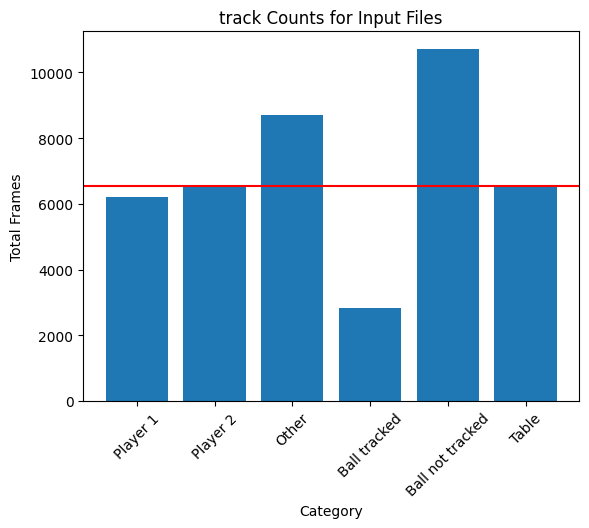

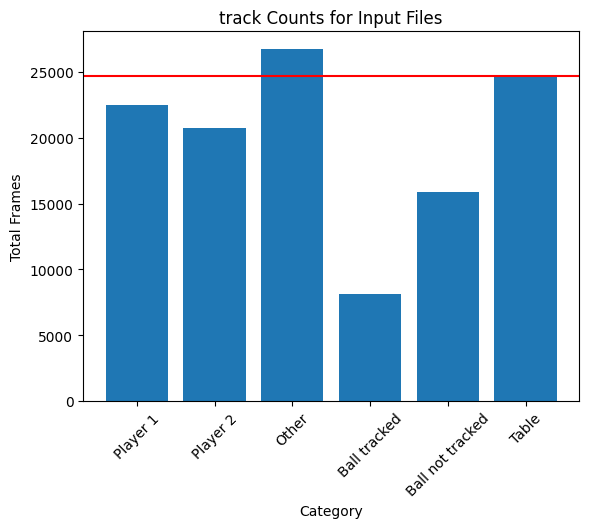

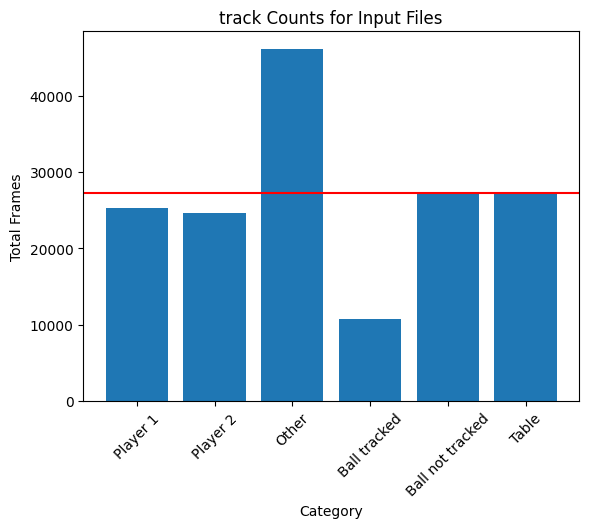

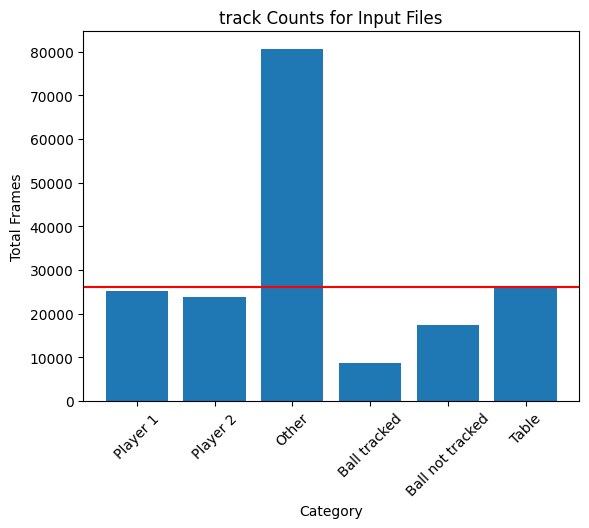

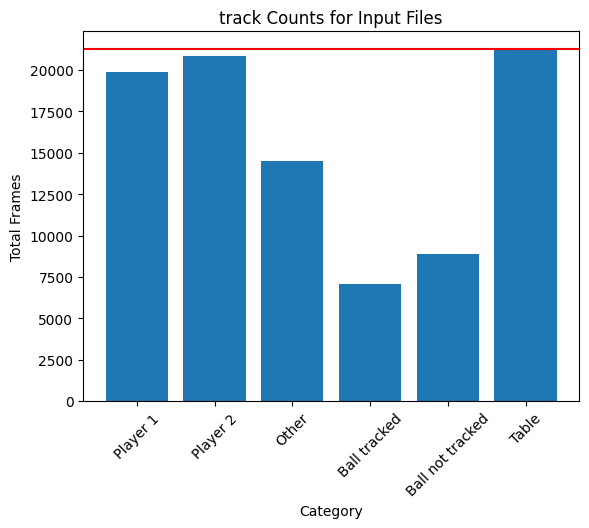

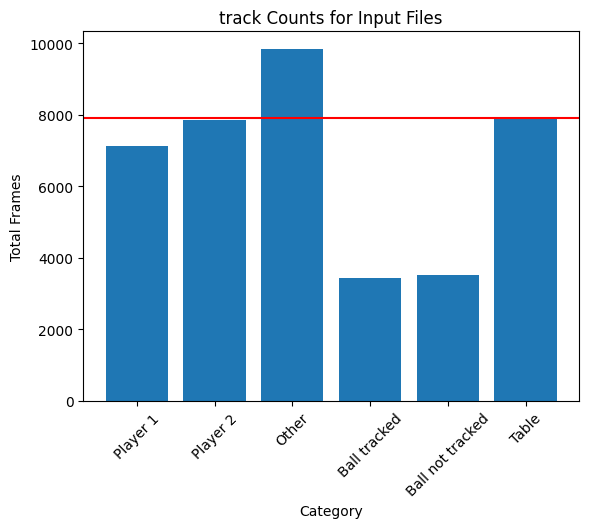

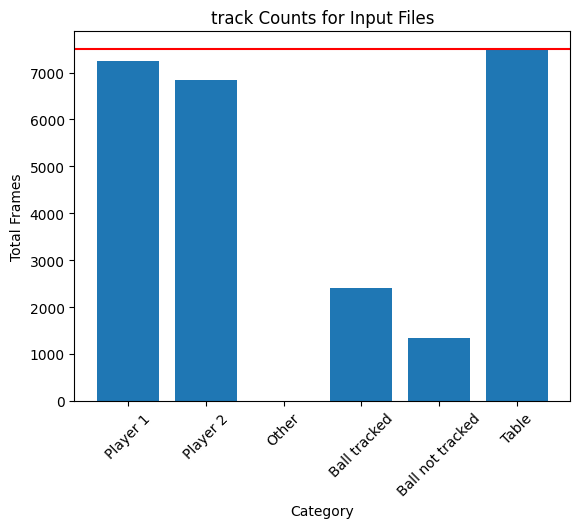

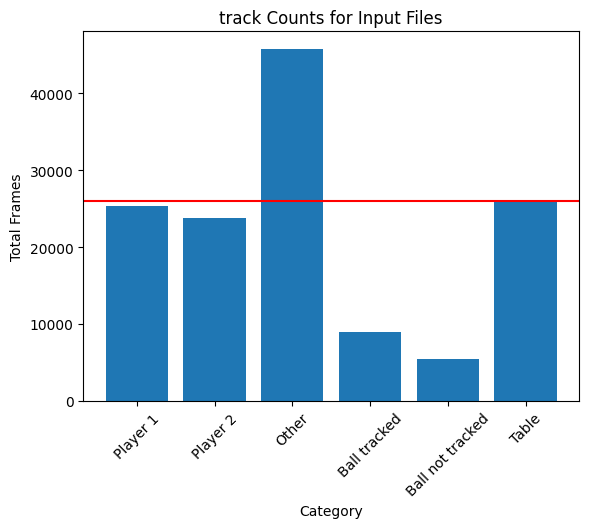

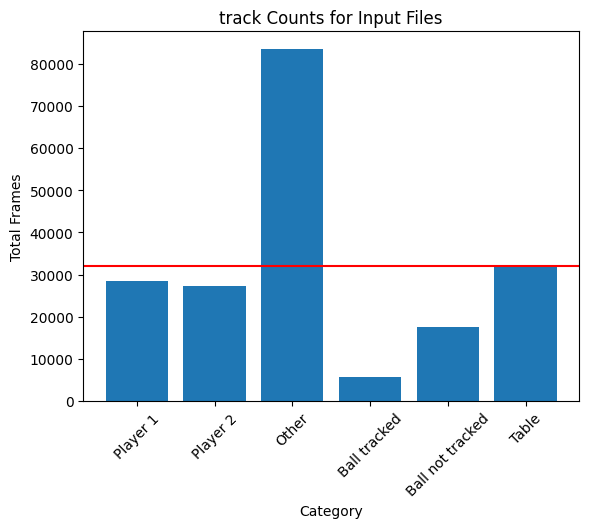

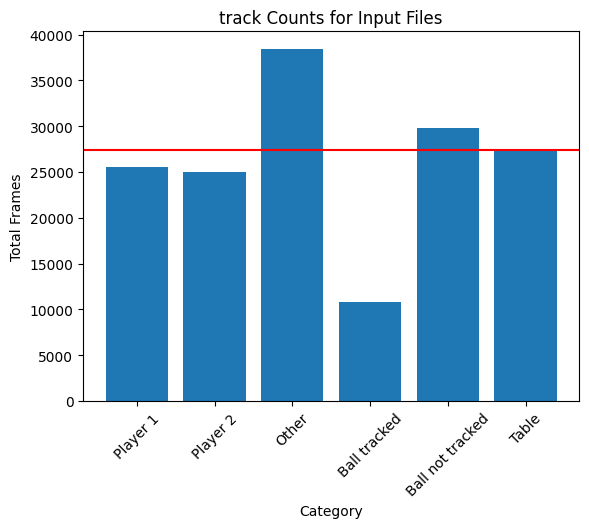

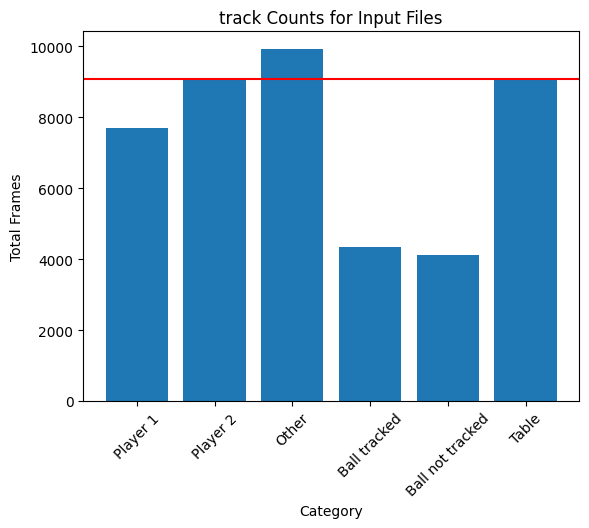

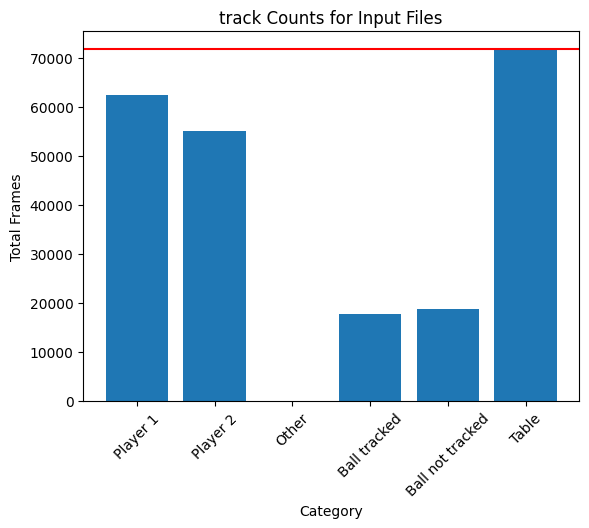

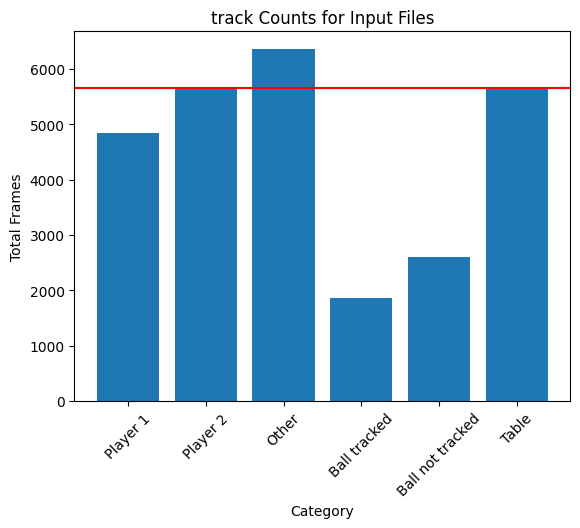

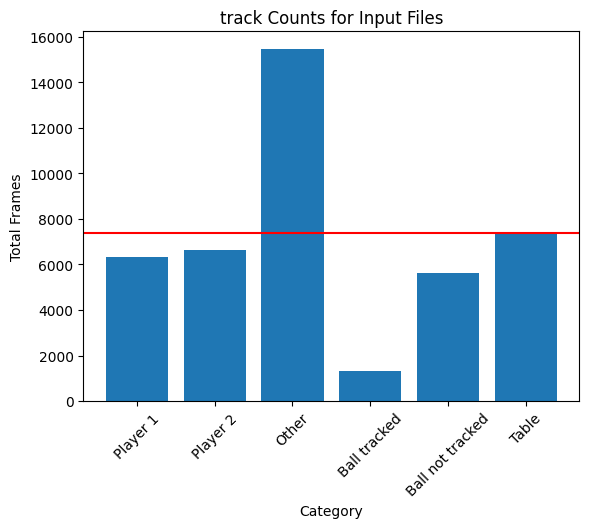

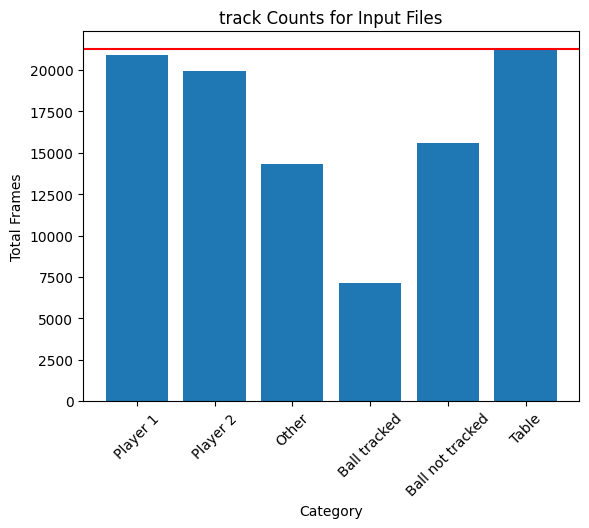

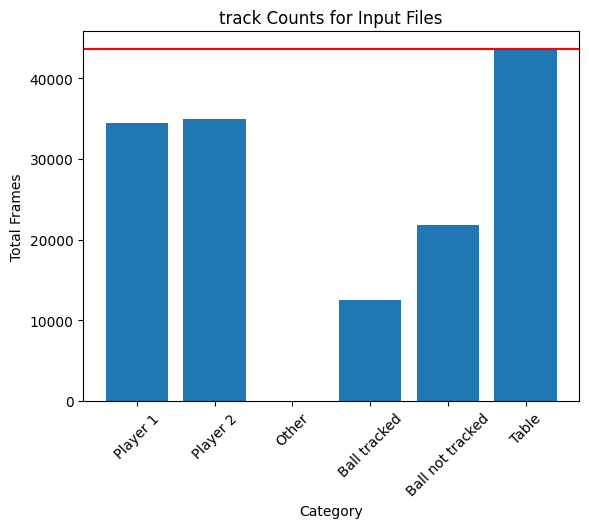

In [ ]:

input_dir = "/content/drive/MyDrive/PRIM/dataset/inputs"
input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.xml')]

for file in input_files:
    totals = {
    "Player 1": 0,
    "Player 2": 0,
    "Other": 0,
    "Ball tracked": 0,
    "Ball not tracked": 0,
    "Table": 0
}
    xml = ET.parse(file)
    number_of_frames = int(xml.find('meta/task/stop_frame').text)

    totals["Player 1"] += count_tracks_by_label(xml, 'Person', role='Player 1')
    totals["Player 2"] += count_tracks_by_label(xml, 'Person', role='Player 2')
    totals["Other"] += count_tracks_by_label(xml, 'Person', role='Other')
    totals["Ball tracked"] += count_tracks_by_label(xml, 'Ball', main=True)
    totals["Ball not tracked"] += count_tracks_by_label(xml, 'Ball', main=False)
    totals["Table"] += count_tracks_by_label(xml, 'Table')

    labels = list(totals.keys())
    counts = list(totals.values())

    plt.bar(labels, counts)
    plt.axhline(y=number_of_frames, color='r', linestyle='-')
    plt.xlabel("Category")
    plt.ylabel("Total Frames")
    plt.title("track Counts for Input Files")
    plt.xticks(rotation=45)
    plt.show()


1. There is a huge variation in noise (by noise I mean the other class and also the untracked balls) accross the different videos. <br>
2. Player 1 and player 2 are almost always equally present. <br>
3. Untracked balls are always more present than the tracked ones. <br>

# II. OUTPUT ANALYSIS

In [ ]:
def analyze_output_files(output_files):
    stats = {
        "strokes": 0,
        "Player 1": 0,
        "Player 2": 0,
        "Serve": 0,
        "Ball pass": 0,
        "Point": 0,
        "Mistake": 0,
        "Let serve": 0,
        "Void serve": 0,
        "Forehand": 0,
        "Backhand": 0,
        "None": 0,
    }

    for output_file in output_files:
        xml = ET.parse(output_file)
        e = EventSequence(xml)
        number_of_frames = int(xml.find('meta/task/stop_frame').text)

        for i in range(number_of_frames):
            if "player 1" in e[i]:
                stats["strokes"] += 1
                stats["Player 1"] += 1
            if "player 2" in e[i]:
                stats["strokes"] += 1
                stats["Player 2"] += 1
            if "serve" in e[i]:
                stats["Serve"] += 1
            if "ball pass" in e[i]:
                stats["Ball pass"] += 1
            if "point" in e[i]:
                stats["Point"] += 1
            if "mistake" in e[i]:
                stats["Mistake"] += 1
            if "let serve" in e[i]:
                stats["Let serve"] += 1
            if "void serve" in e[i]:
                stats["Void serve"] += 1
            if "forehand" in e[i]:
                stats["Forehand"] += 1
            if "backhand" in e[i]:
                stats["Backhand"] += 1
            if not e[i]:
                stats["None"] += 1

        # Print stats for the current video
        print(f"Stats for {output_file}:")
        for key, value in stats.items():
            print(f"{key}: {value}")

        # Create and display pie charts
        # Strokes vs. Non-Strokes
        labels = ['Strokes', 'Non-Strokes']
        sizes = [stats["strokes"], number_of_frames - stats["strokes"]]
        plt.figure(figsize=(5, 5))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title("Strokes vs. Non-Strokes")
        plt.show()

        # Player 1 vs. Player 2
        labels = ['Player 1', 'Player 2']
        sizes = [stats["Player 1"], stats["Player 2"]]
        plt.figure(figsize=(5, 5))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title("Player 1 vs. Player 2")
        plt.show()

        # Backhand vs. Forehand
        labels = ['Backhand', 'Forehand']
        sizes = [stats["Backhand"], stats["Forehand"]]
        plt.figure(figsize=(5, 5))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title("Backhand vs. Forehand")
        plt.show()

        # Serve, Ball Pass, and Other Strokes
        other_strokes = stats["strokes"] - stats["Serve"] - stats["Ball pass"]
        labels = ['Serve', 'Ball Pass', 'None']
        sizes = [stats["Serve"], stats["Ball pass"], other_strokes]
        plt.figure(figsize=(5, 5))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title("Serve, Ball Pass, and Other Strokes")
        plt.show()

        # Point, Mistake, Let Serve, Void Serve, and Other Strokes
        other_strokes = stats["strokes"] - stats["Point"] - stats["Mistake"] - stats["Let serve"] - stats["Void serve"]
        labels = ['Point', 'Mistake', 'Let Serve', 'Void Serve', 'None']
        sizes = [stats["Point"], stats["Mistake"], stats["Let serve"], stats["Void serve"], other_strokes]
        plt.figure(figsize=(5, 5))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title("Point, Mistake, Let Serve, Void Serve, and Other Strokes")
        plt.show()

        # Reset stats for the next video
        stats = {
            "strokes": 0,
            "Player 1": 0,
            "Player 2": 0,
            "Serve": 0,
            "Ball pass": 0,
            "Point": 0,
            "Mistake": 0,
            "Let serve": 0,
            "Void serve": 0,
            "Forehand": 0,
            "Backhand": 0,
            "None": 0,
        }

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/hjefd.xml:
strokes: 39
Player 1: 22
Player 2: 17
Serve: 8
Ball pass: 7
Point: 0
Mistake: 8
Let serve: 0
Void serve: 0
Forehand: 20
Backhand: 19
None: 21233


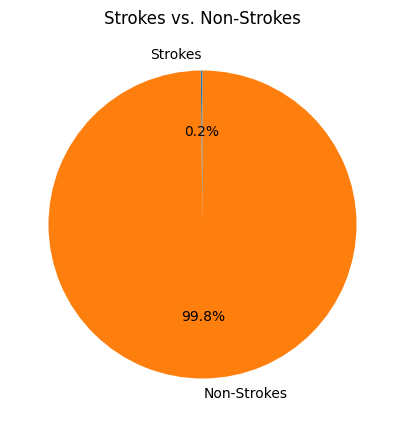

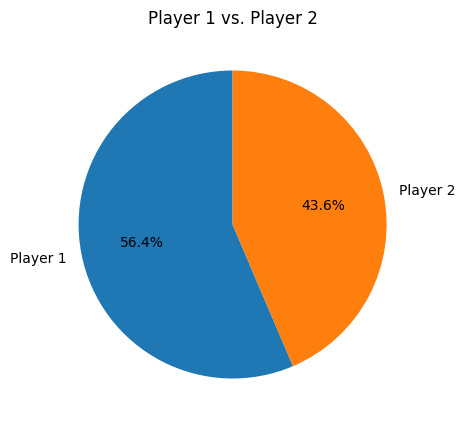

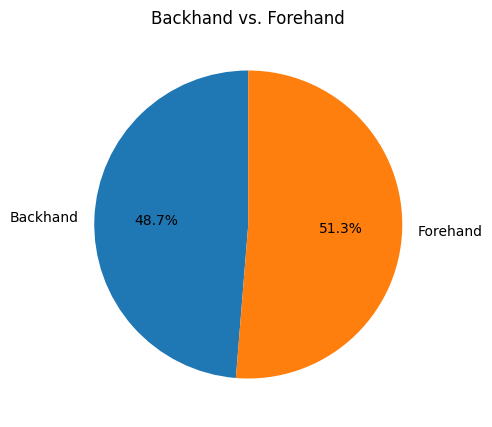

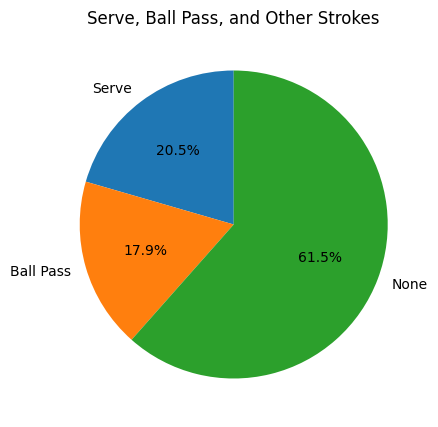

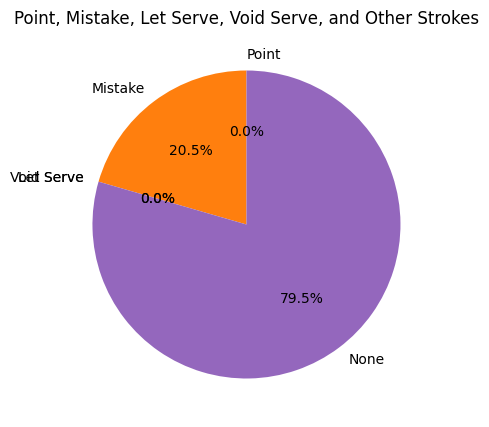

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/alatn.xml:
strokes: 197
Player 1: 95
Player 2: 102
Serve: 37
Ball pass: 23
Point: 9
Mistake: 31
Let serve: 1
Void serve: 1
Forehand: 73
Backhand: 123
None: 19843


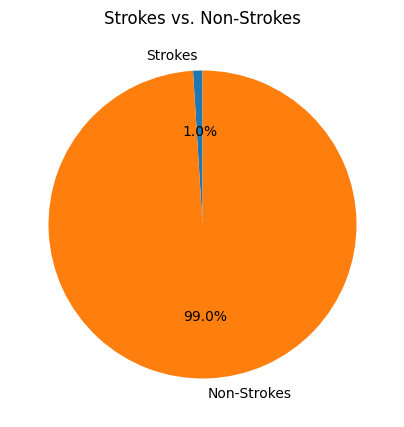

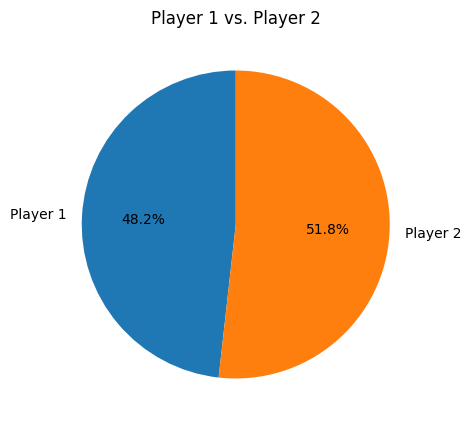

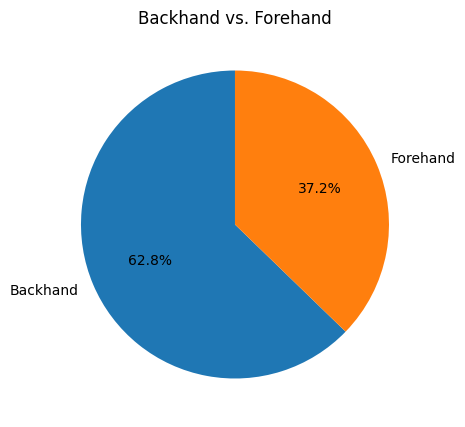

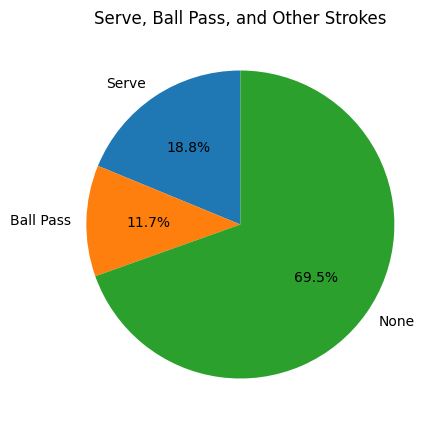

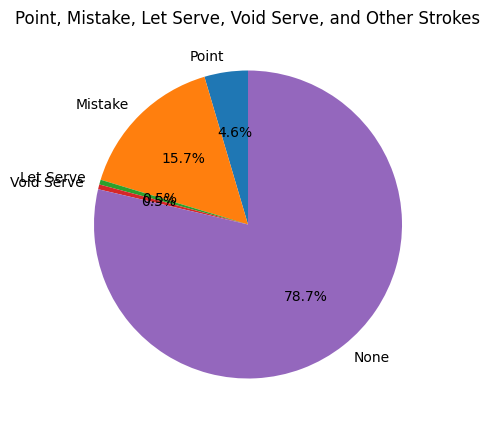

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/tbhzi.xml:
strokes: 81
Player 1: 44
Player 2: 37
Serve: 20
Ball pass: 13
Point: 2
Mistake: 18
Let serve: 2
Void serve: 0
Forehand: 34
Backhand: 47
None: 6469


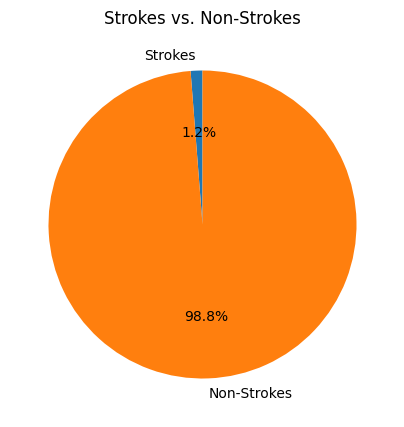

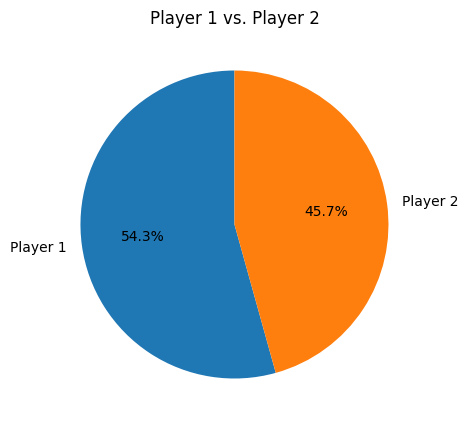

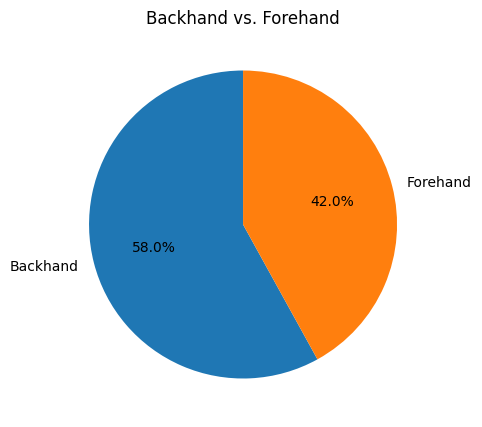

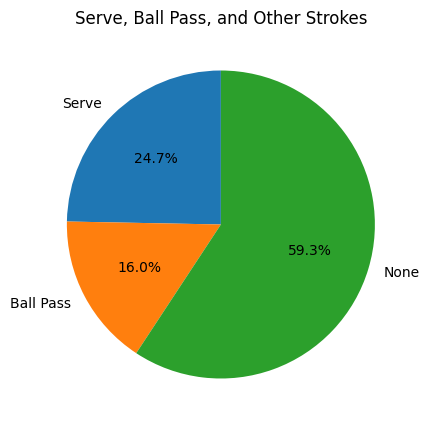

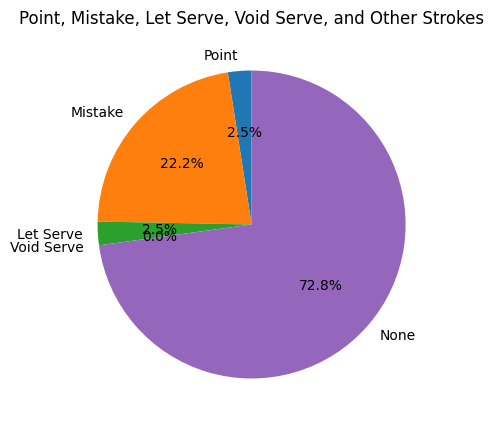

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/mdhln.xml:
strokes: 69
Player 1: 35
Player 2: 34
Serve: 17
Ball pass: 7
Point: 4
Mistake: 11
Let serve: 0
Void serve: 2
Forehand: 27
Backhand: 43
None: 7384


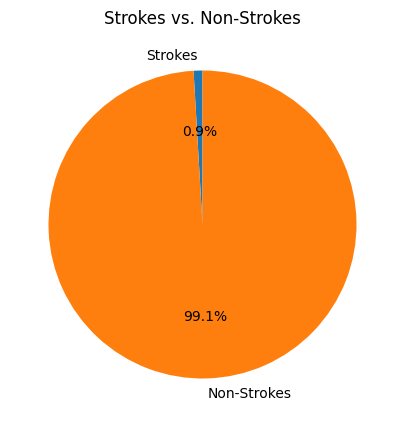

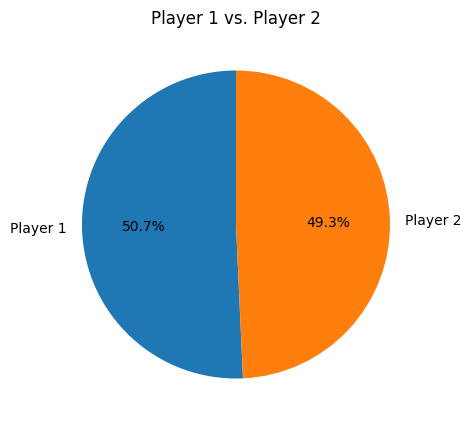

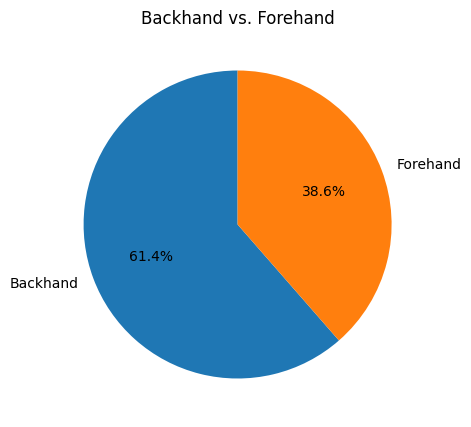

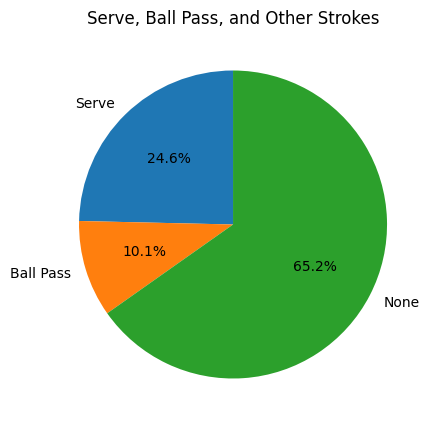

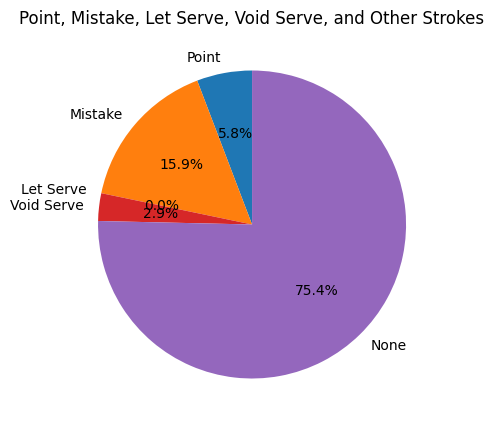

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/enekh.xml:
strokes: 109
Player 1: 52
Player 2: 57
Serve: 17
Ball pass: 11
Point: 3
Mistake: 14
Let serve: 0
Void serve: 0
Forehand: 39
Backhand: 70
None: 7514


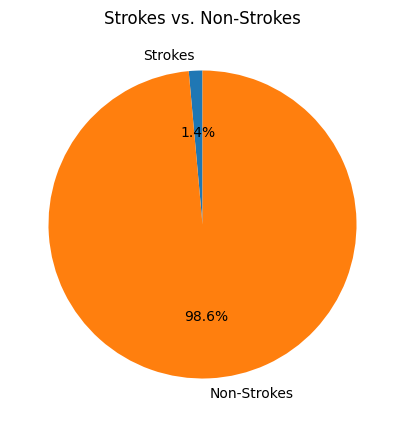

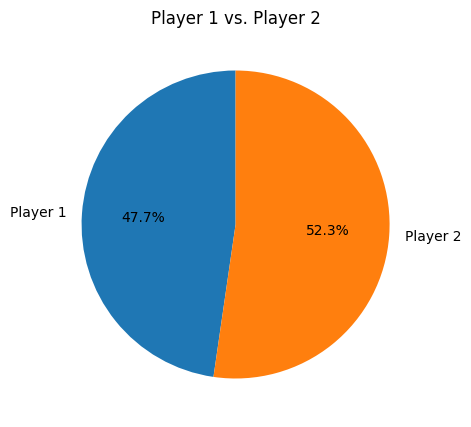

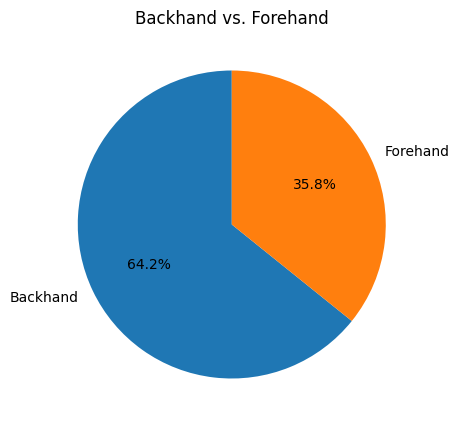

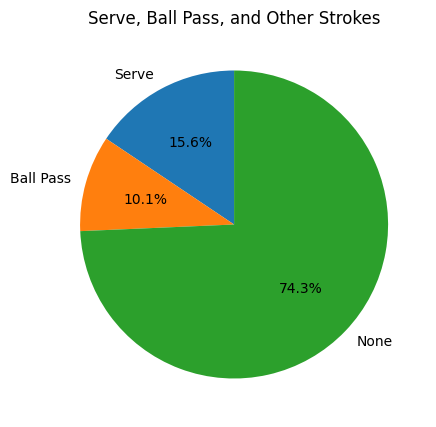

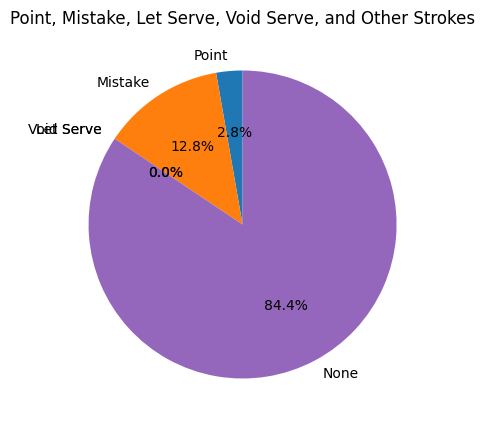

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/sckat.xml:
strokes: 160
Player 1: 81
Player 2: 79
Serve: 26
Ball pass: 8
Point: 7
Mistake: 18
Let serve: 0
Void serve: 0
Forehand: 60
Backhand: 100
None: 8926


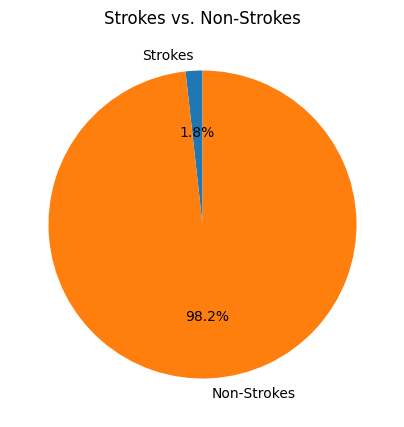

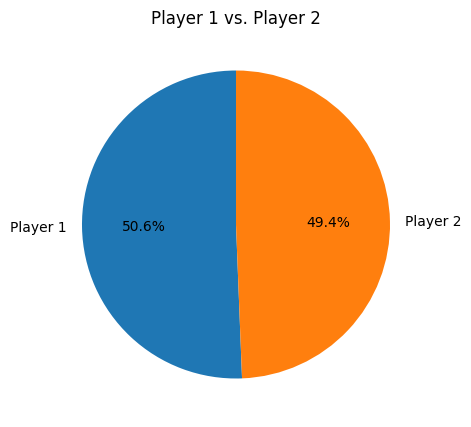

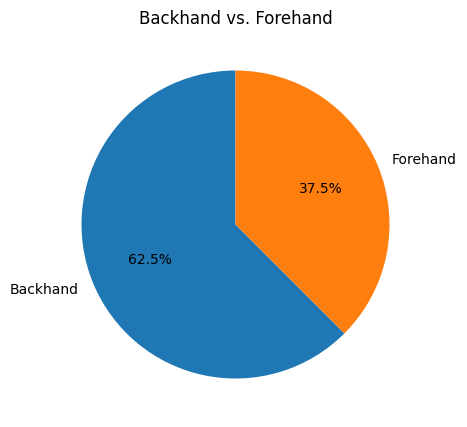

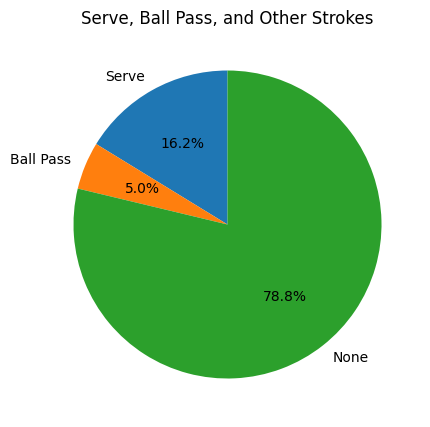

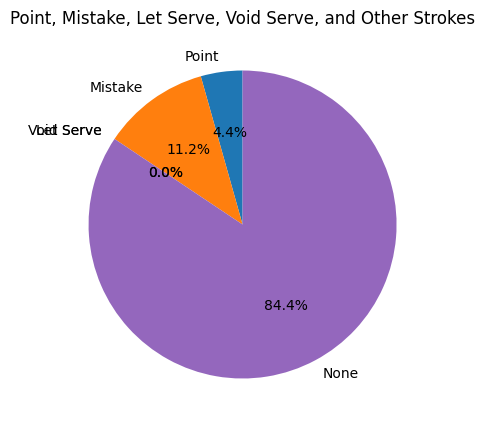

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/hucjj.xml:
strokes: 91
Player 1: 45
Player 2: 46
Serve: 20
Ball pass: 8
Point: 2
Mistake: 19
Let serve: 1
Void serve: 0
Forehand: 53
Backhand: 38
None: 7833


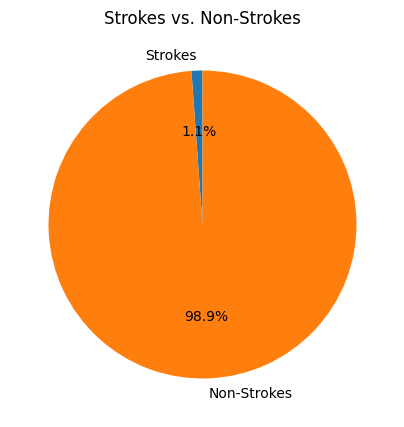

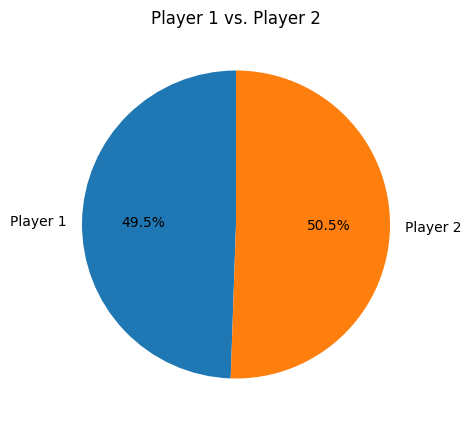

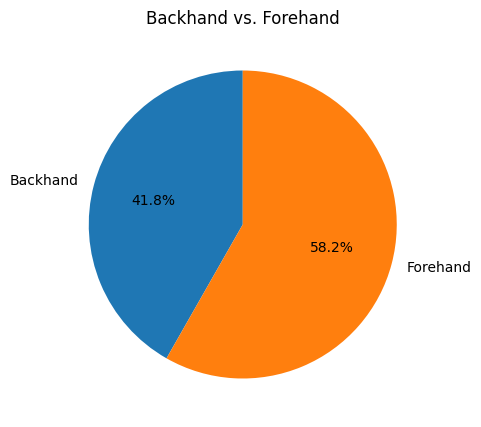

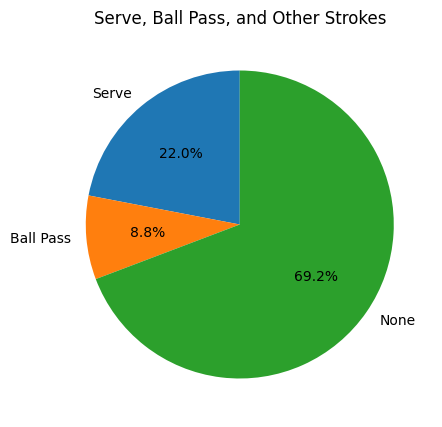

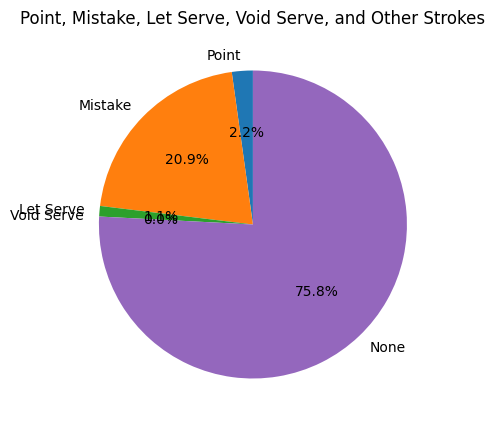

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/ipohn.xml:
strokes: 681
Player 1: 339
Player 2: 342
Serve: 96
Ball pass: 48
Point: 5
Mistake: 93
Let serve: 0
Void serve: 3
Forehand: 240
Backhand: 442
None: 49499


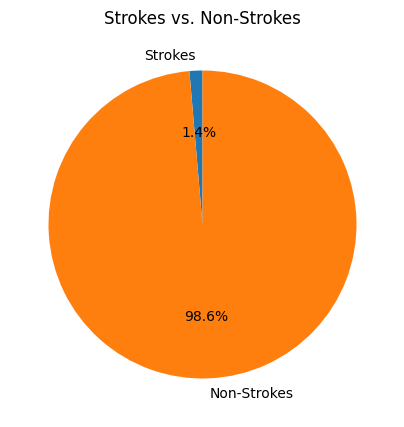

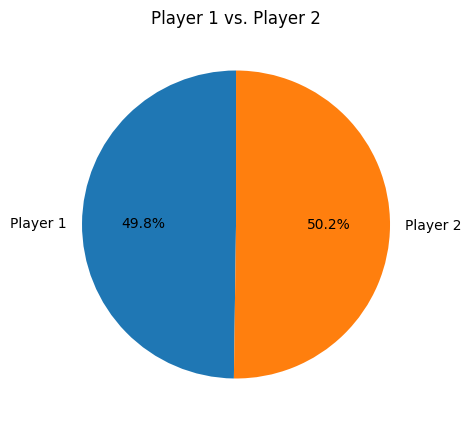

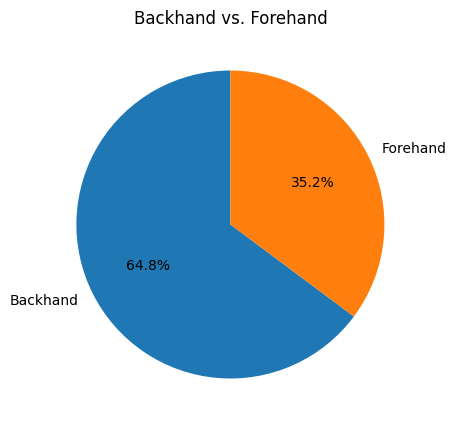

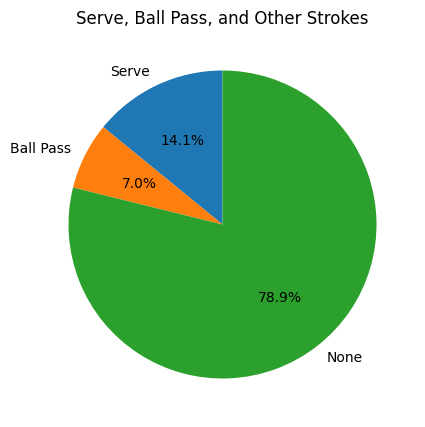

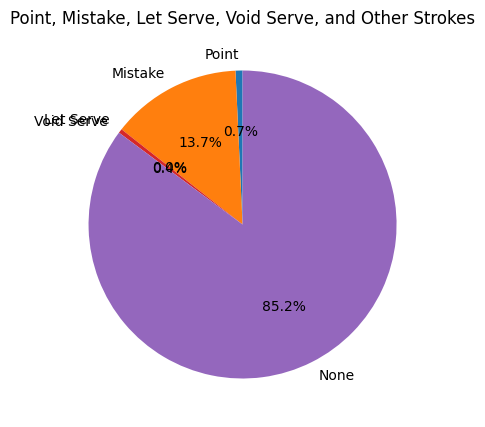

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/zsvsn.xml:
strokes: 301
Player 1: 145
Player 2: 156
Serve: 59
Ball pass: 25
Point: 8
Mistake: 47
Let serve: 0
Void serve: 4
Forehand: 139
Backhand: 160
None: 25872


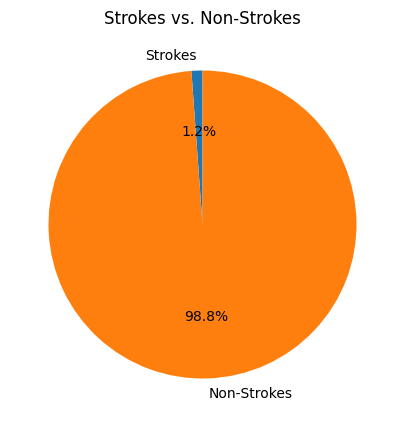

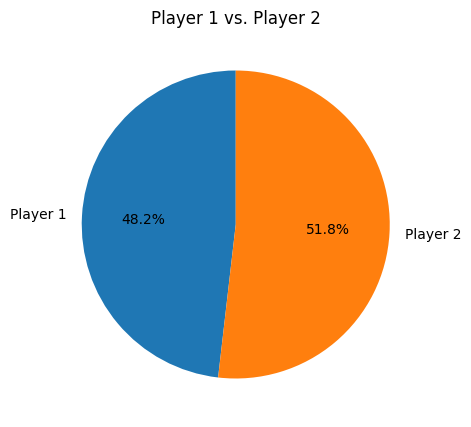

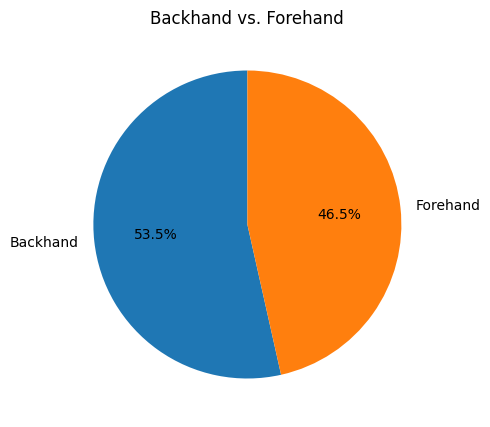

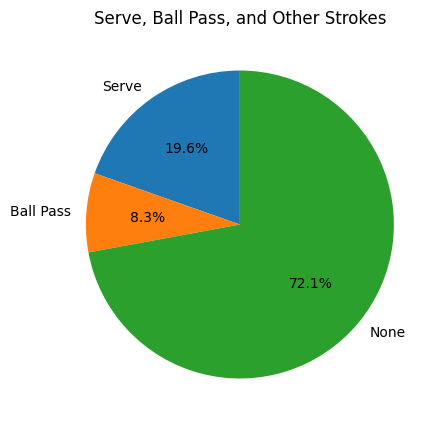

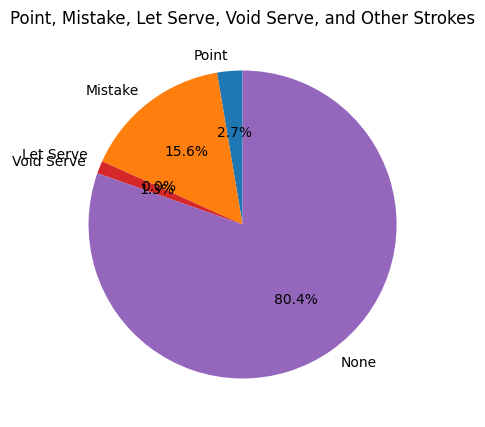

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/giplk.xml:
strokes: 82
Player 1: 43
Player 2: 39
Serve: 21
Ball pass: 5
Point: 5
Mistake: 14
Let serve: 2
Void serve: 0
Forehand: 56
Backhand: 26
None: 4861


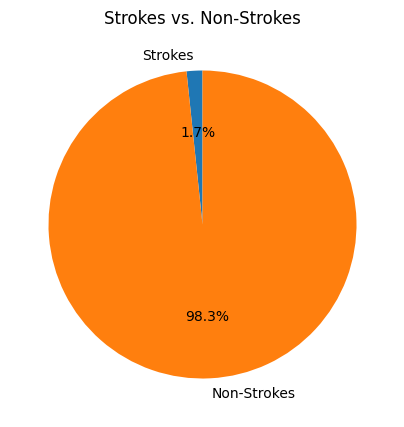

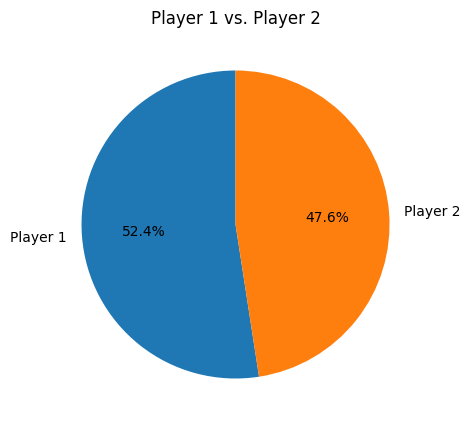

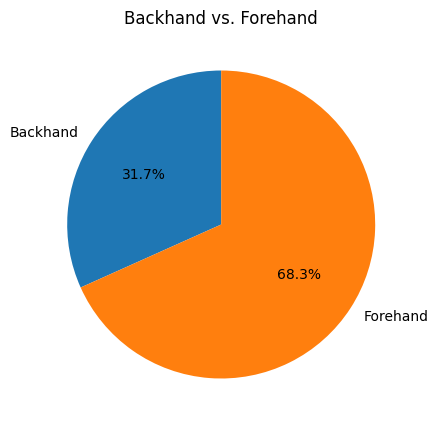

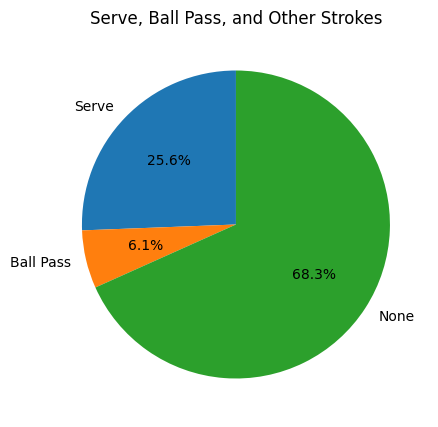

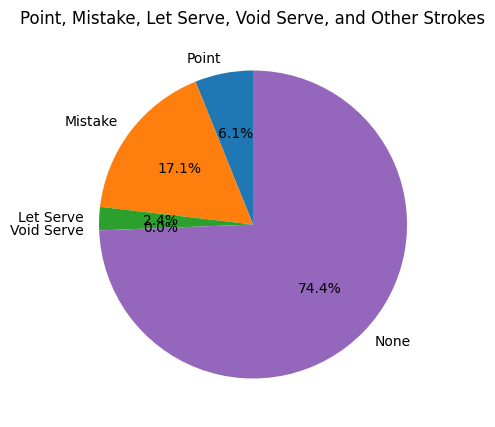

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/nxbhc.xml:
strokes: 75
Player 1: 36
Player 2: 39
Serve: 14
Ball pass: 11
Point: 2
Mistake: 13
Let serve: 0
Void serve: 0
Forehand: 34
Backhand: 41
None: 6449


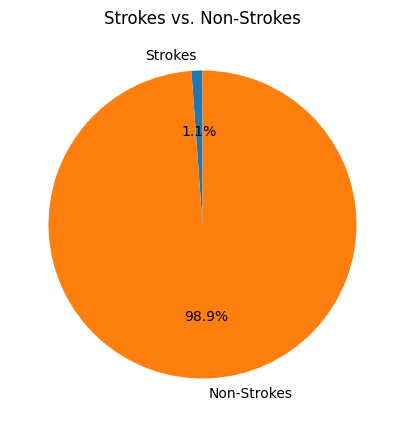

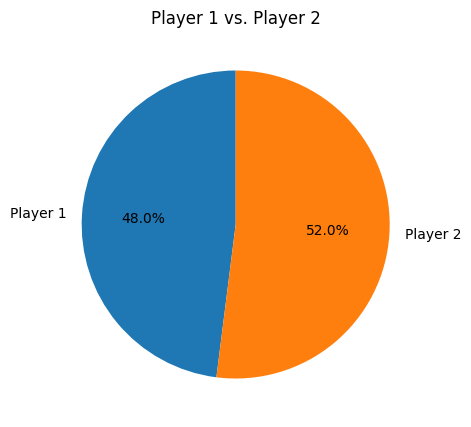

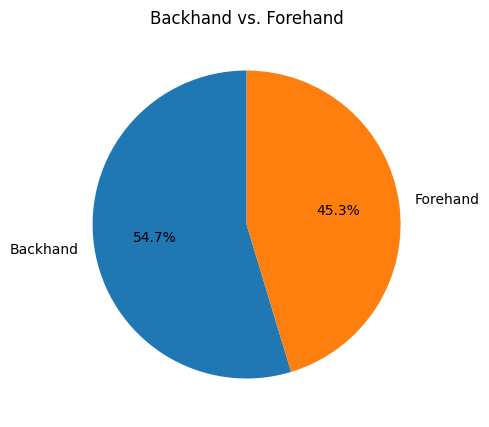

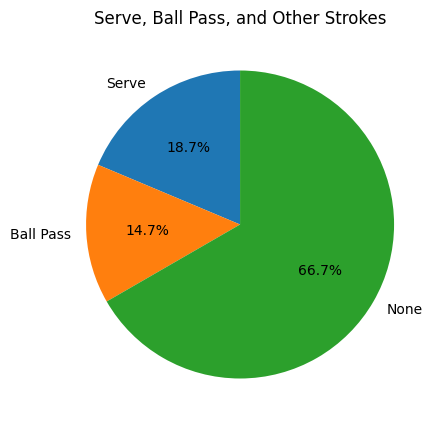

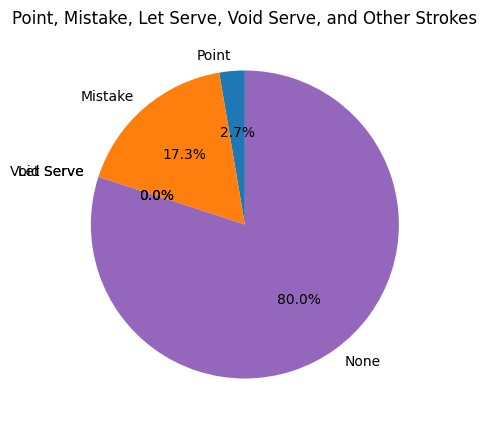

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/rtrwk.xml:
strokes: 114
Player 1: 57
Player 2: 57
Serve: 14
Ball pass: 2
Point: 3
Mistake: 13
Let serve: 0
Void serve: 0
Forehand: 12
Backhand: 102
None: 4073


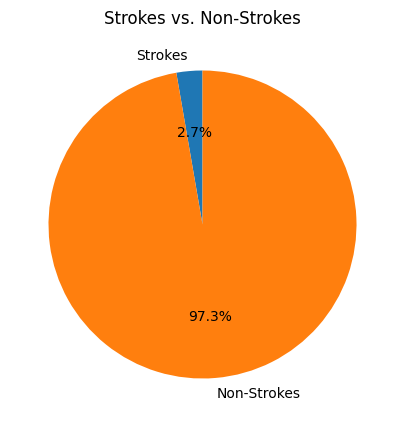

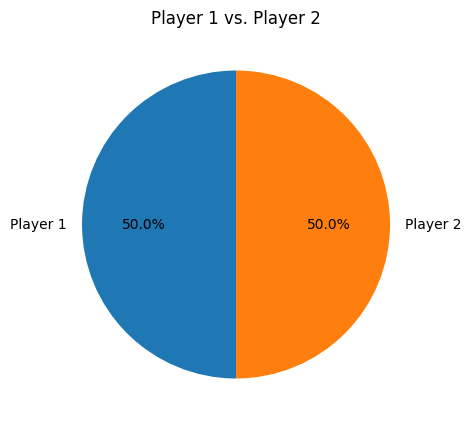

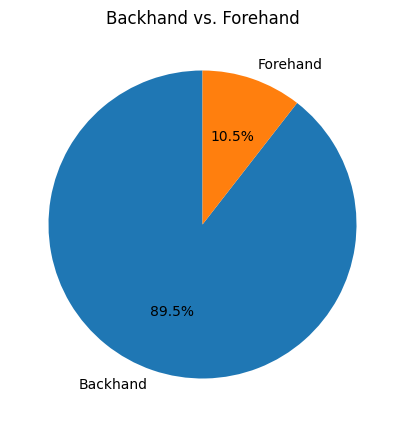

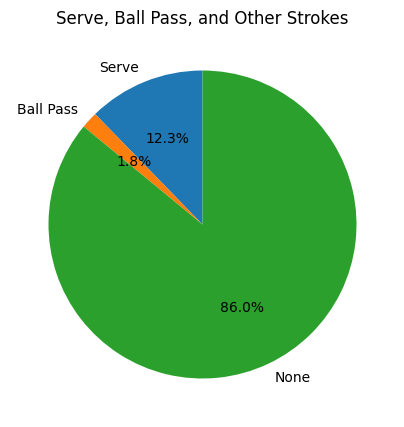

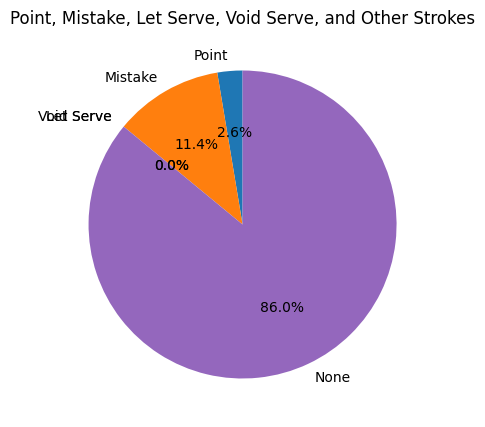

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/ygfdz.xml:
strokes: 66
Player 1: 33
Player 2: 33
Serve: 17
Ball pass: 5
Point: 2
Mistake: 17
Let serve: 0
Void serve: 0
Forehand: 31
Backhand: 33
None: 5585


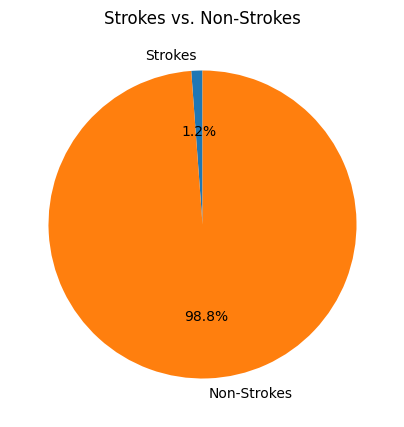

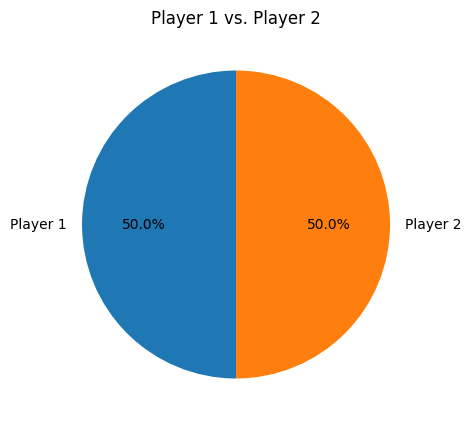

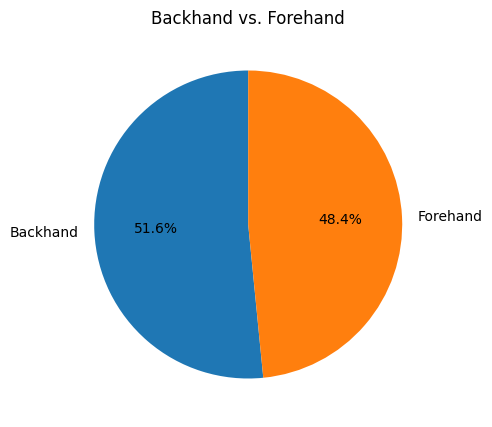

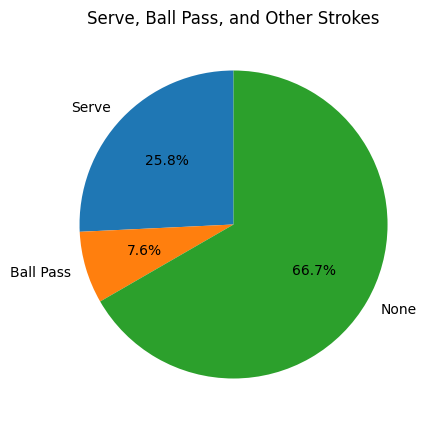

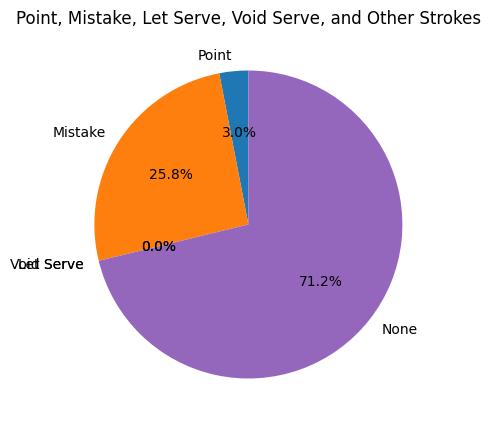

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/bnivh.xml:
strokes: 217
Player 1: 110
Player 2: 107
Serve: 49
Ball pass: 18
Point: 5
Mistake: 45
Let serve: 0
Void serve: 0
Forehand: 140
Backhand: 77
None: 18112


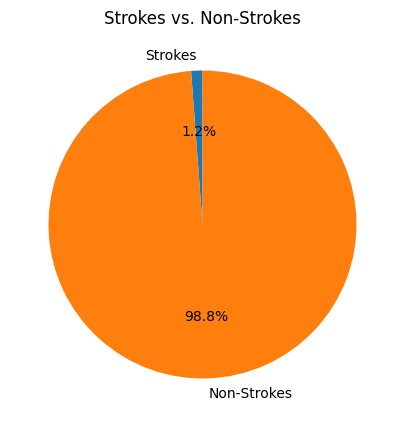

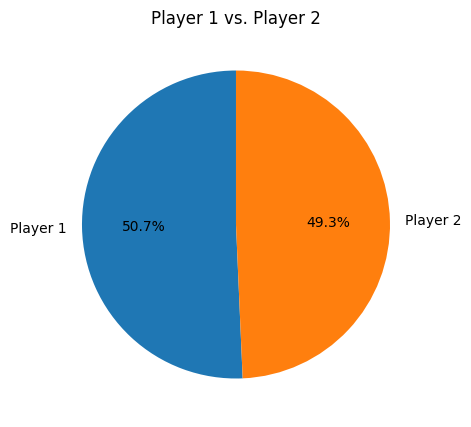

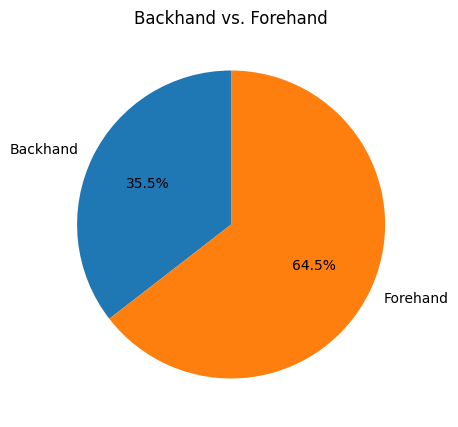

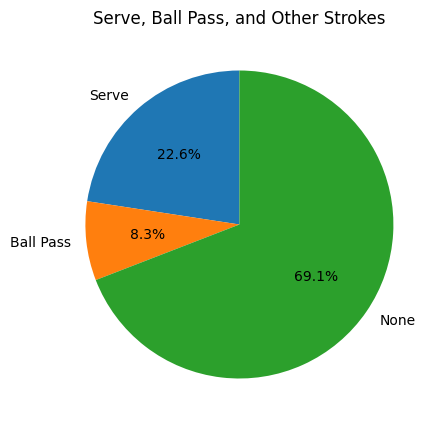

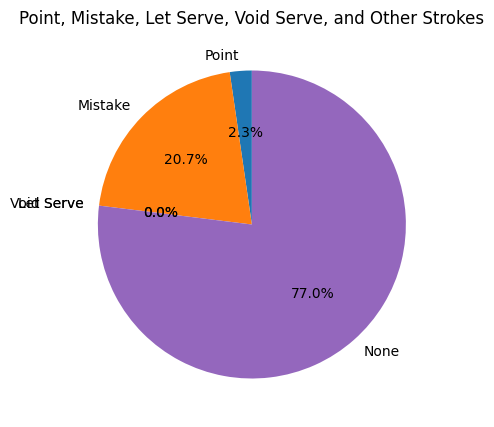

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/homwl.xml:
strokes: 208
Player 1: 100
Player 2: 108
Serve: 55
Ball pass: 27
Point: 10
Mistake: 45
Let serve: 1
Void serve: 0
Forehand: 102
Backhand: 106
None: 19919


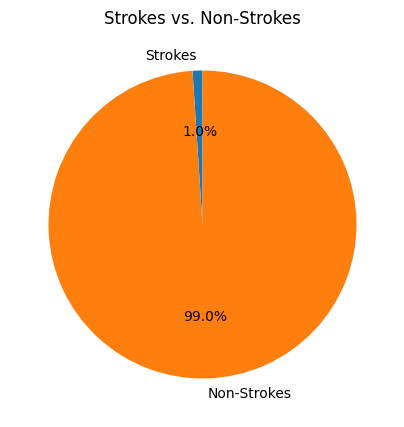

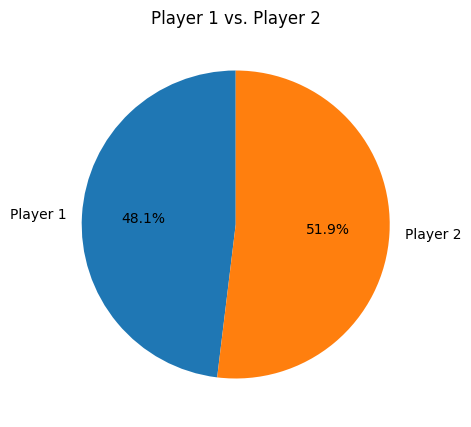

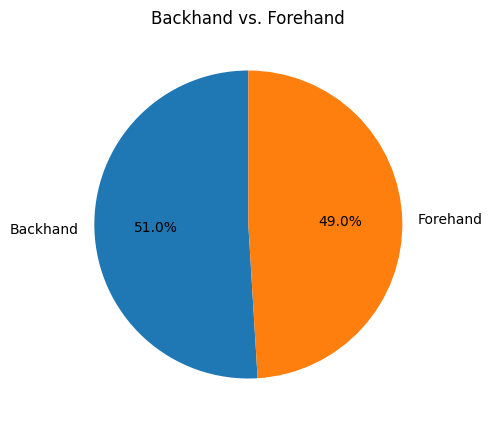

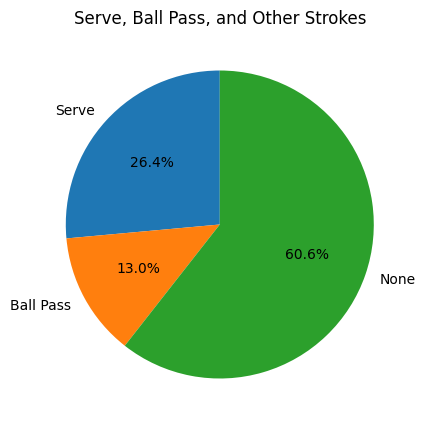

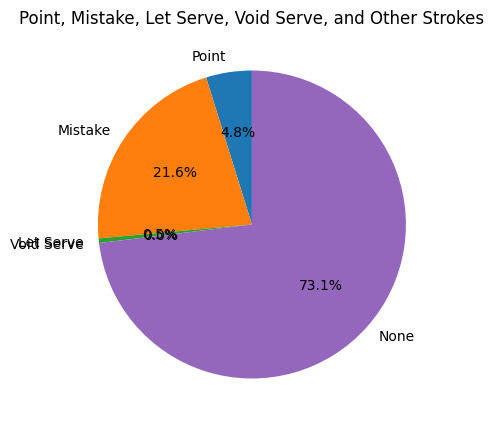

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/zidxm.xml:
strokes: 454
Player 1: 222
Player 2: 232
Serve: 74
Ball pass: 36
Point: 10
Mistake: 64
Let serve: 1
Void serve: 0
Forehand: 188
Backhand: 266
None: 26866


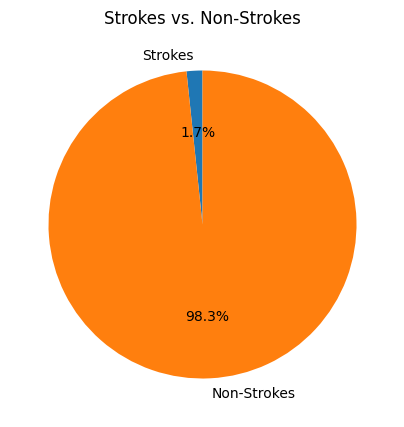

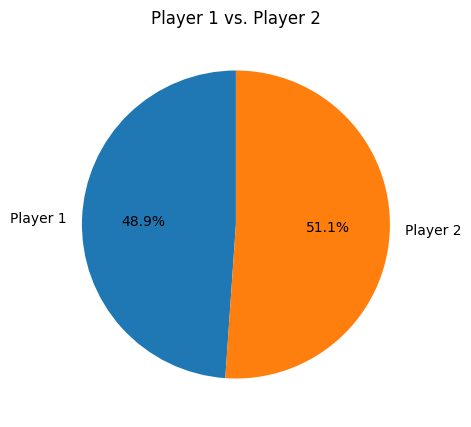

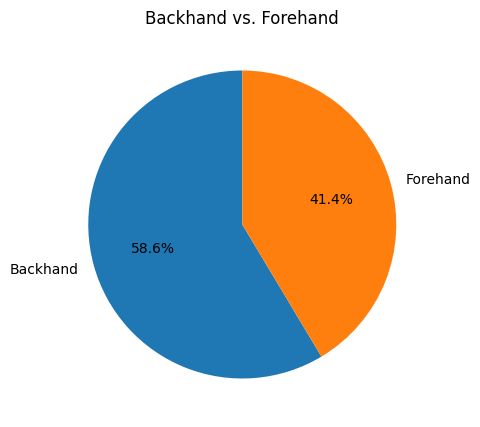

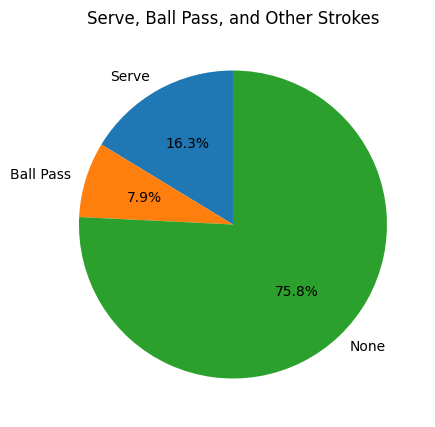

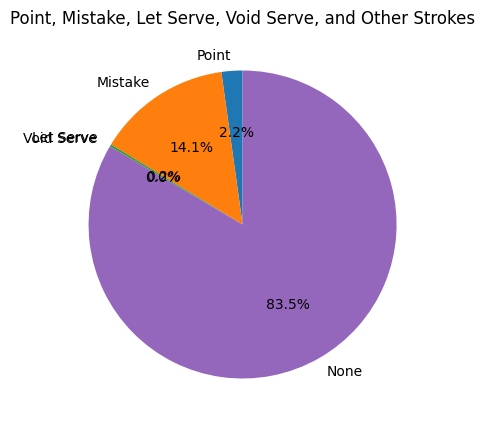

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/odsnu.xml:
strokes: 405
Player 1: 203
Player 2: 202
Serve: 93
Ball pass: 47
Point: 14
Mistake: 79
Let serve: 1
Void serve: 0
Forehand: 184
Backhand: 221
None: 25592


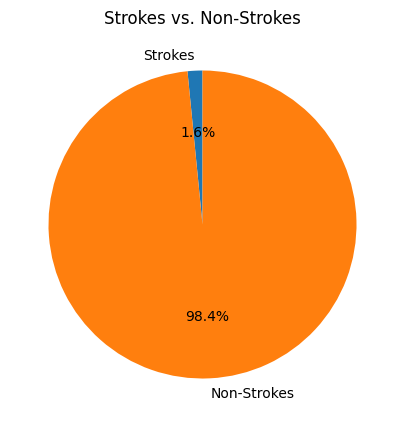

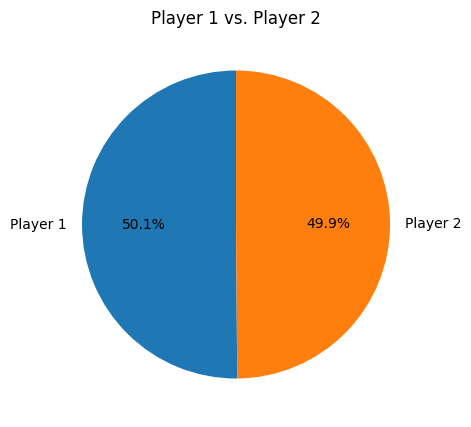

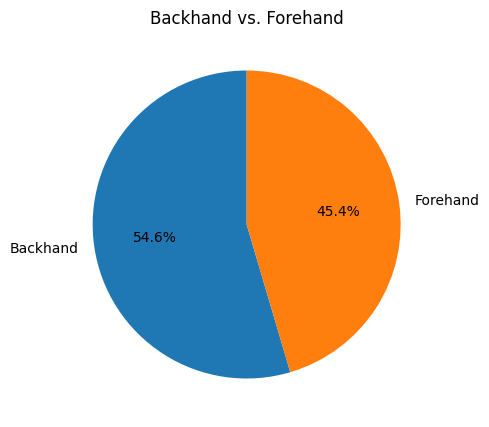

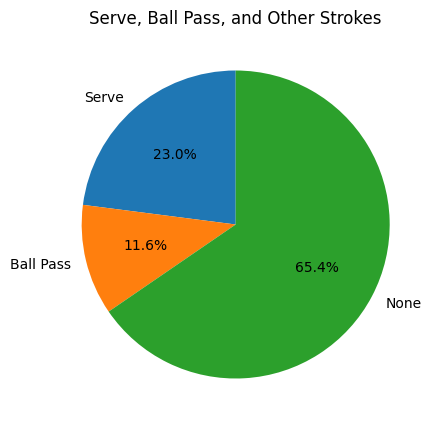

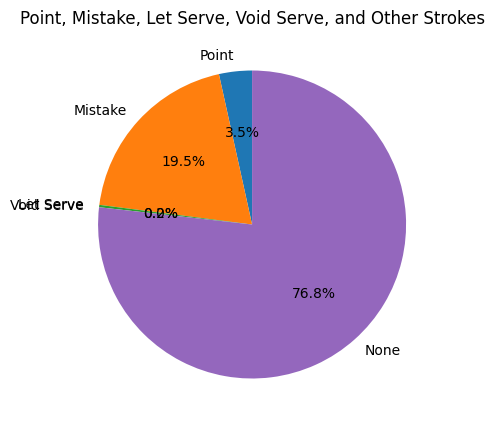

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/szgdk.xml:
strokes: 86
Player 1: 44
Player 2: 42
Serve: 18
Ball pass: 7
Point: 0
Mistake: 19
Let serve: 1
Void serve: 0
Forehand: 44
Backhand: 40
None: 7969


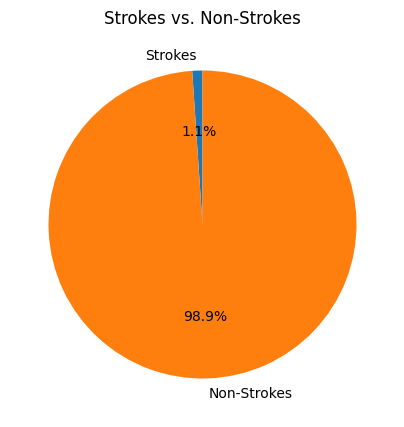

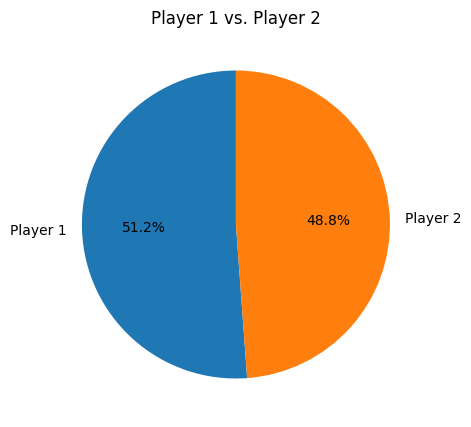

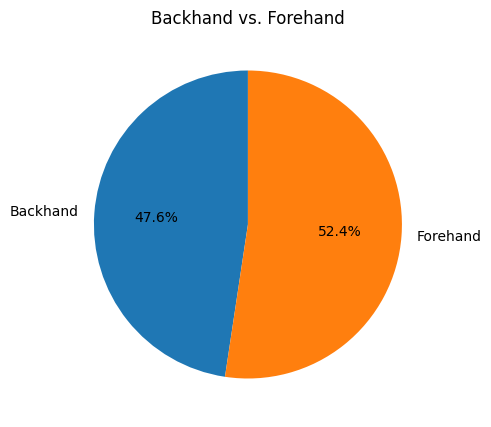

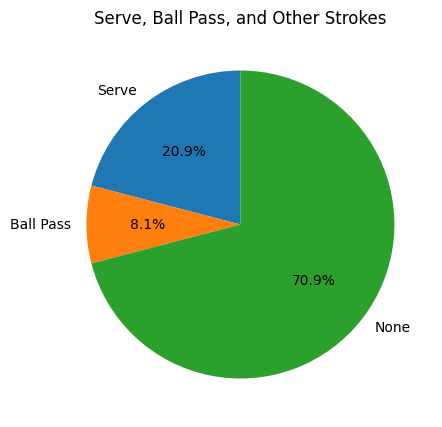

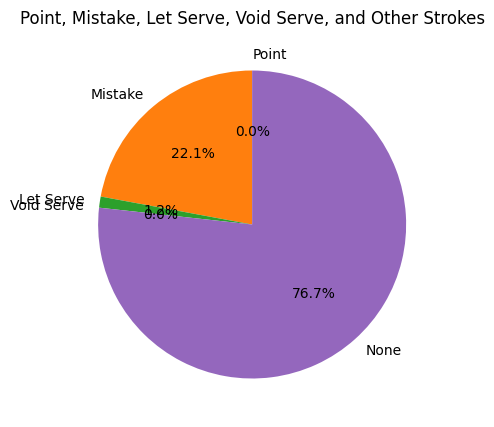

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/ypkjg.xml:
strokes: 321
Player 1: 159
Player 2: 162
Serve: 72
Ball pass: 33
Point: 6
Mistake: 64
Let serve: 3
Void serve: 0
Forehand: 197
Backhand: 124
None: 24371


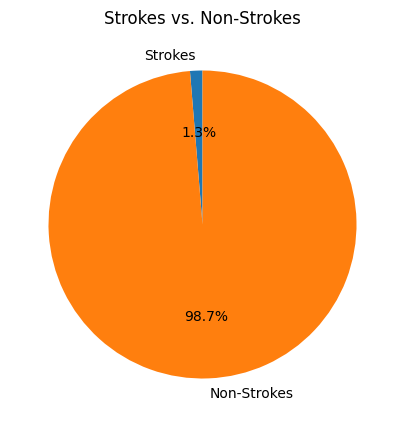

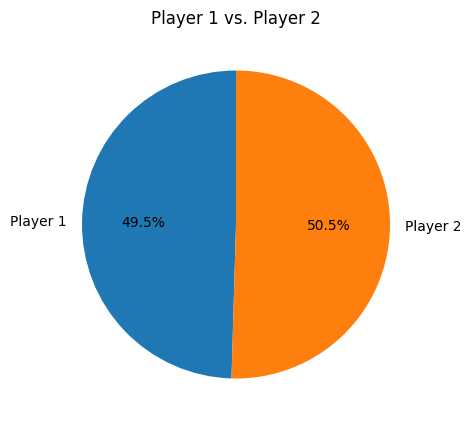

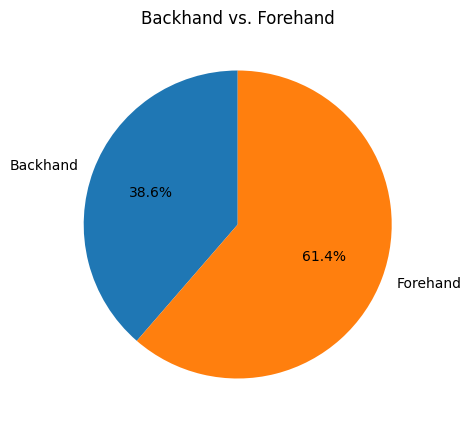

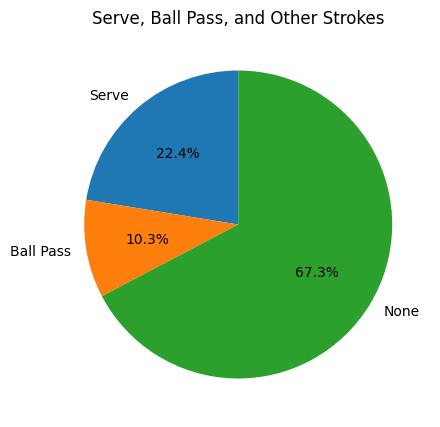

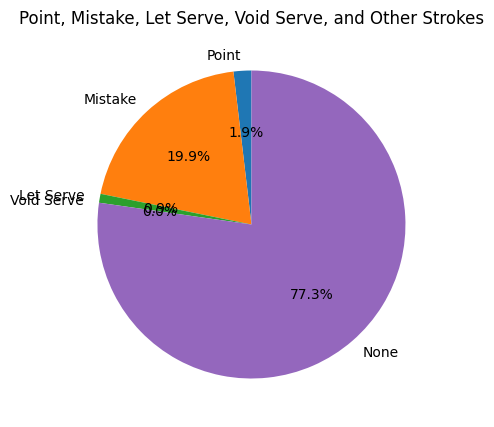

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/owagb.xml:
strokes: 271
Player 1: 139
Player 2: 132
Serve: 56
Ball pass: 24
Point: 8
Mistake: 59
Let serve: 0
Void serve: 1
Forehand: 171
Backhand: 100
None: 31863


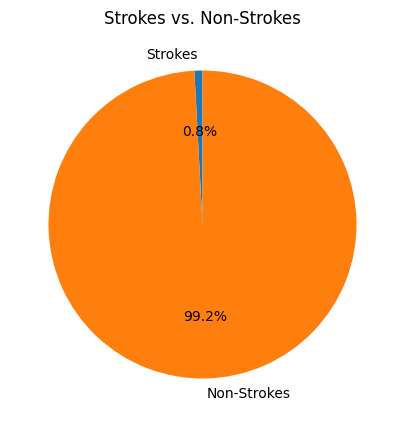

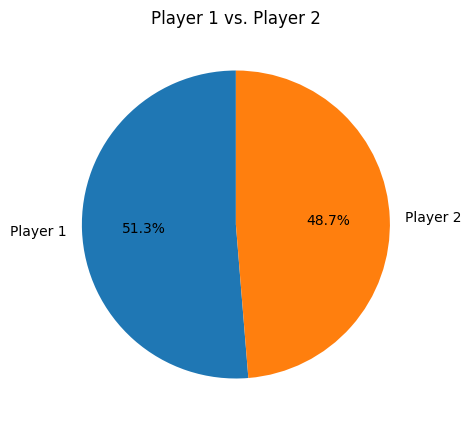

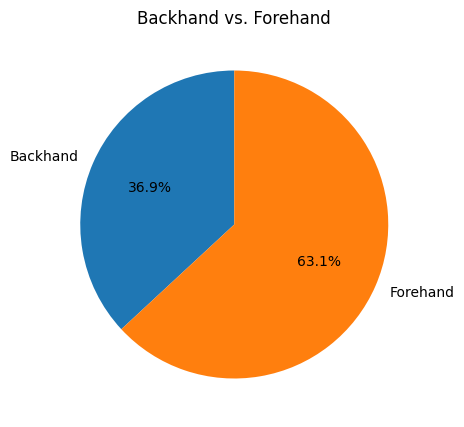

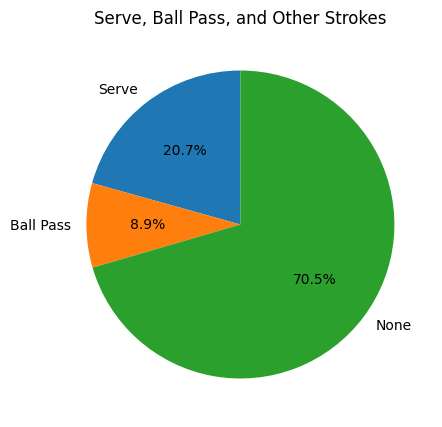

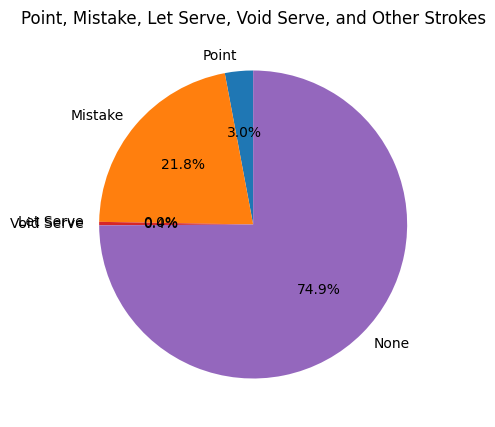

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/zbzpb.xml:
strokes: 118
Player 1: 58
Player 2: 60
Serve: 17
Ball pass: 9
Point: 1
Mistake: 18
Let serve: 0
Void serve: 0
Forehand: 57
Backhand: 61
None: 7252


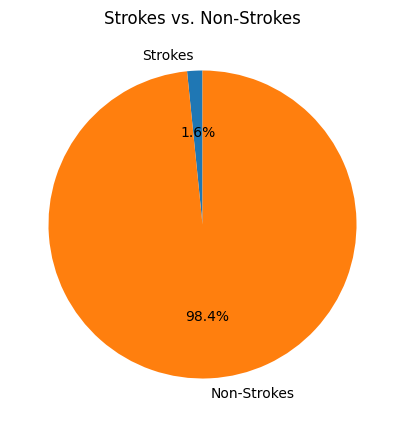

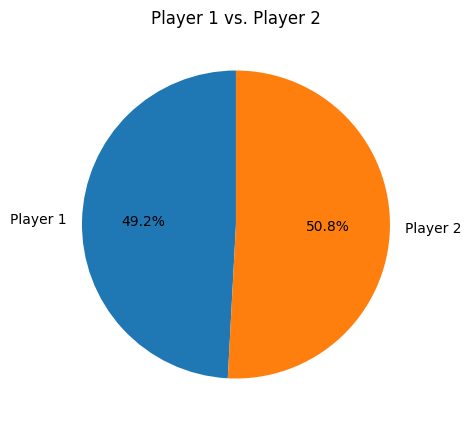

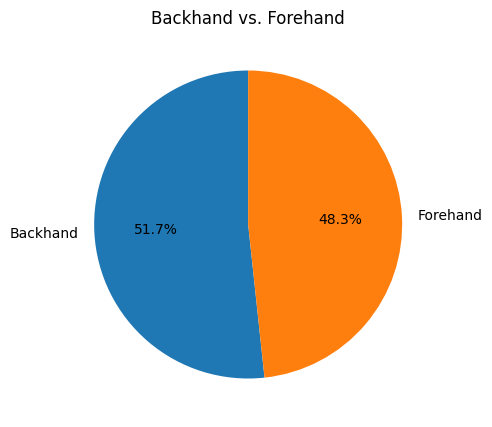

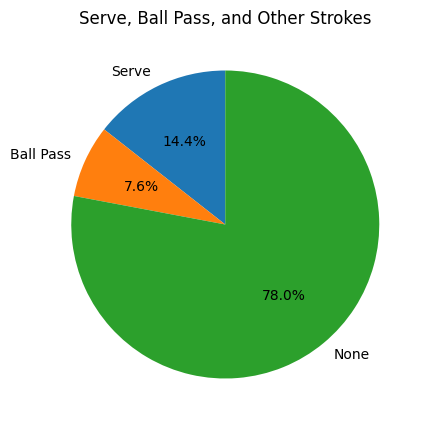

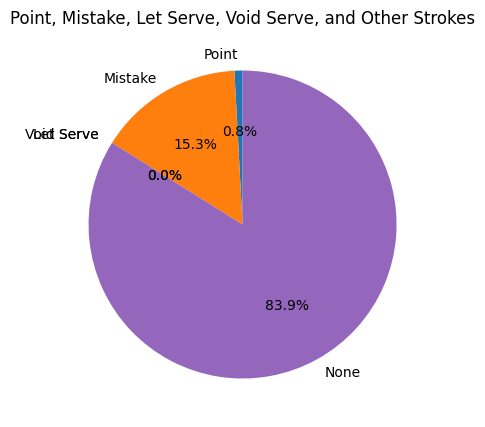

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/xunmo.xml:
strokes: 467
Player 1: 231
Player 2: 236
Serve: 110
Ball pass: 57
Point: 13
Mistake: 95
Let serve: 2
Void serve: 0
Forehand: 313
Backhand: 154
None: 71369


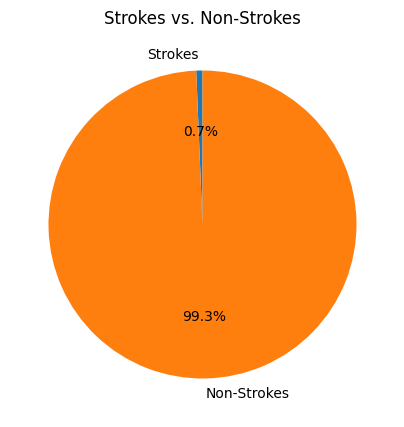

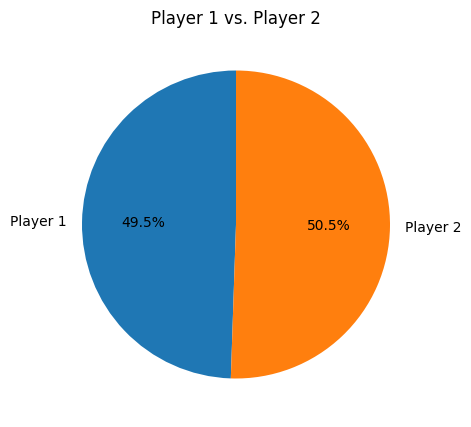

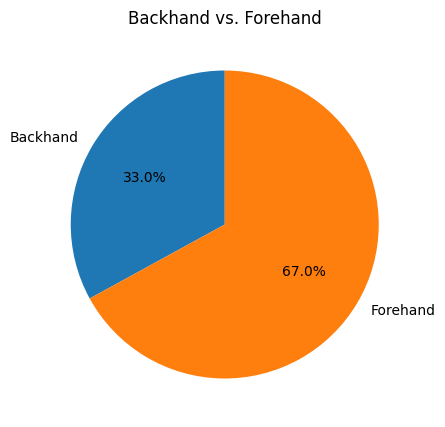

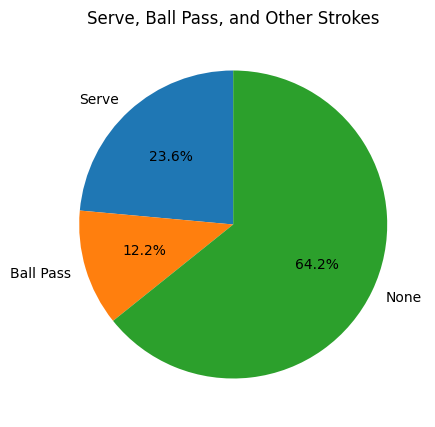

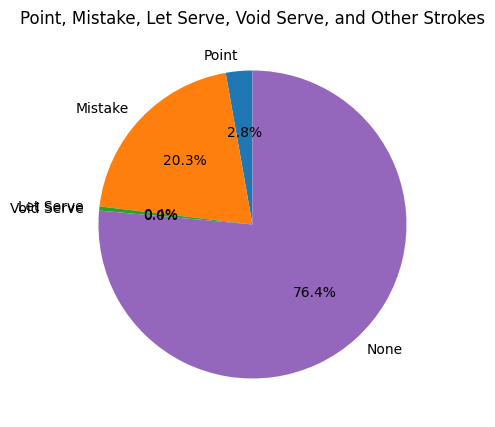

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/edysv.xml:
strokes: 220
Player 1: 106
Player 2: 114
Serve: 52
Ball pass: 29
Point: 10
Mistake: 40
Let serve: 4
Void serve: 0
Forehand: 97
Backhand: 123
None: 27278


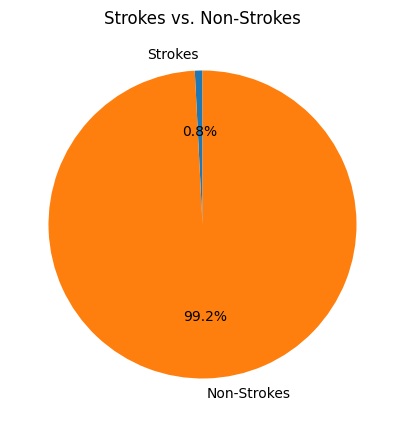

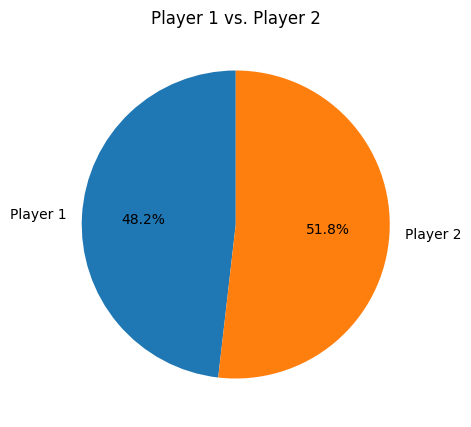

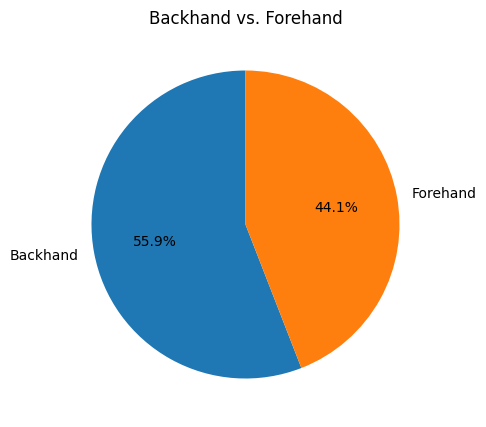

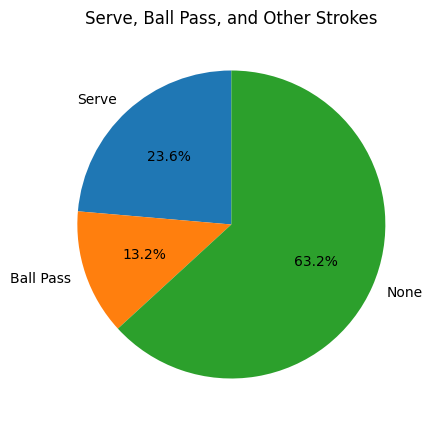

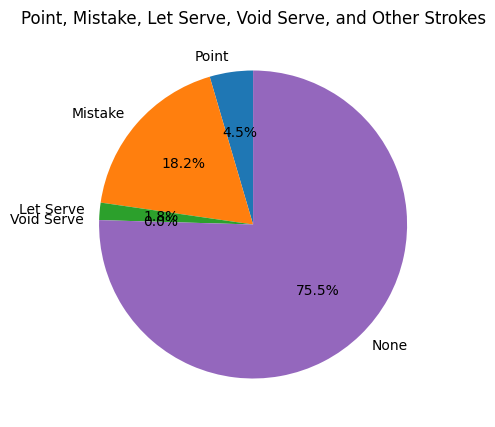

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/wmrgi.xml:
strokes: 455
Player 1: 236
Player 2: 219
Serve: 103
Ball pass: 43
Point: 13
Mistake: 84
Let serve: 5
Void serve: 4
Forehand: 180
Backhand: 274
None: 43158


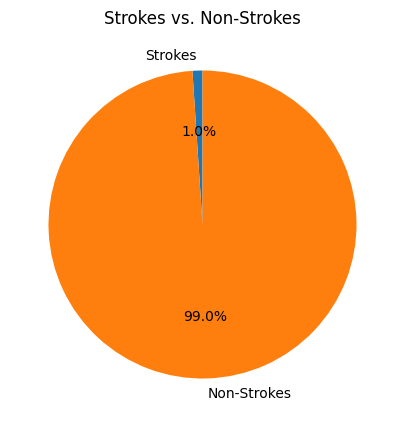

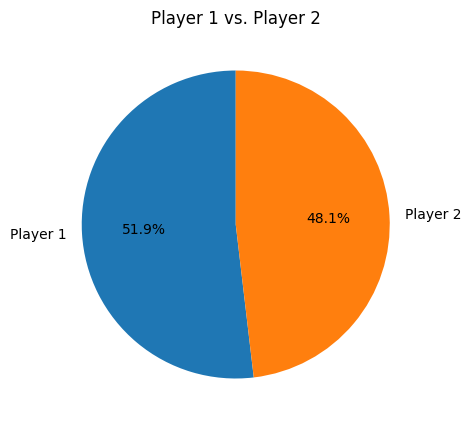

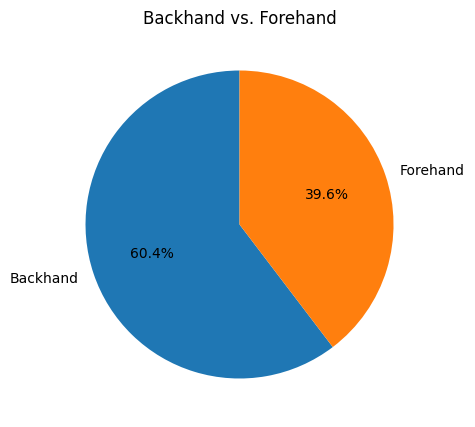

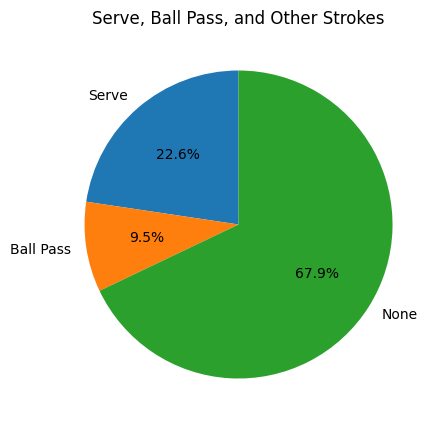

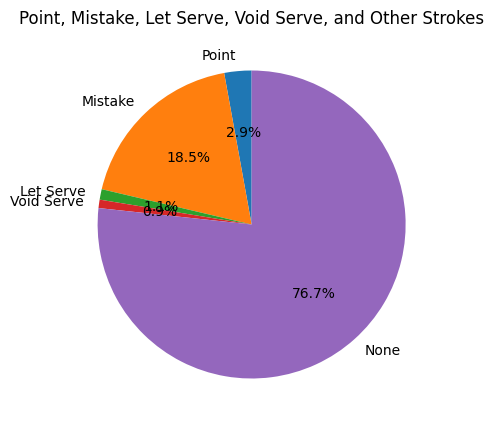

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/nrxwh.xml:
strokes: 187
Player 1: 94
Player 2: 93
Serve: 40
Ball pass: 17
Point: 3
Mistake: 35
Let serve: 0
Void serve: 2
Forehand: 94
Backhand: 92
None: 44226


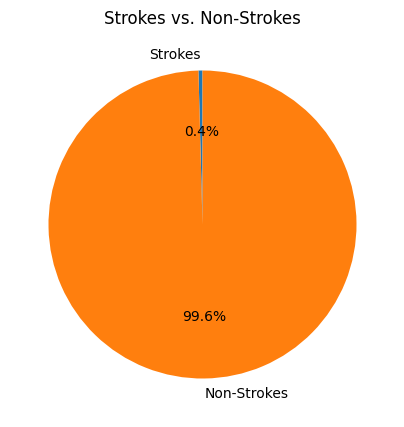

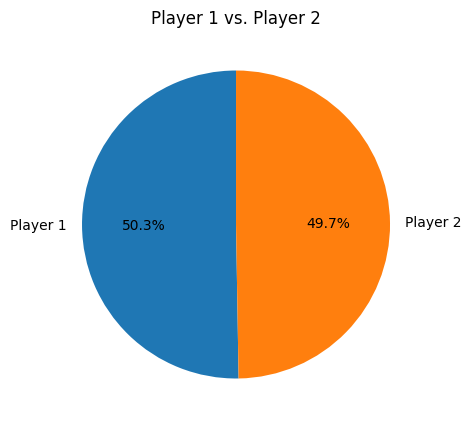

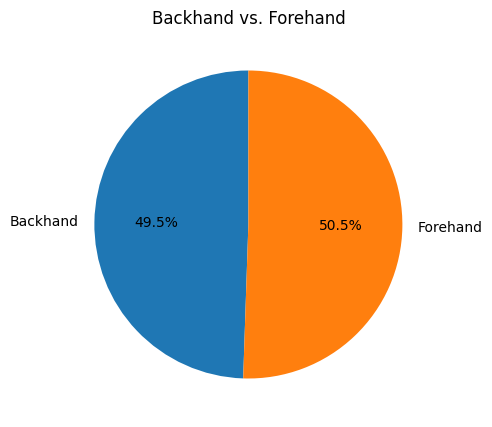

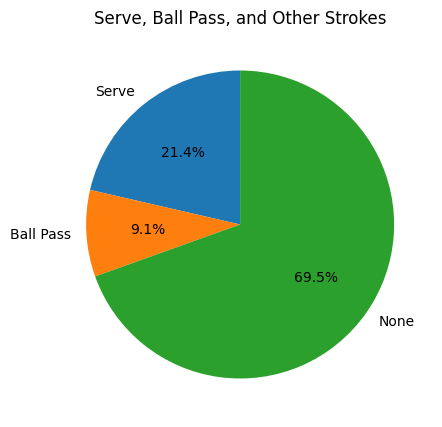

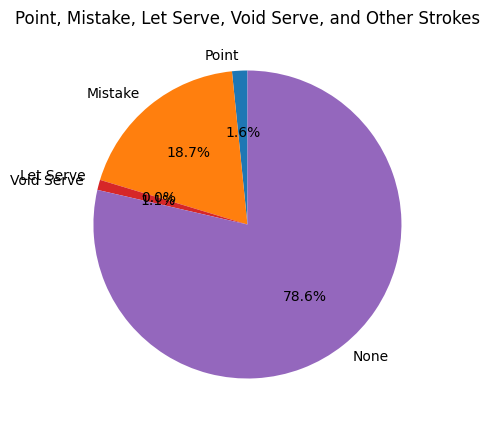

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/mehxb.xml:
strokes: 101
Player 1: 52
Player 2: 49
Serve: 21
Ball pass: 9
Point: 6
Mistake: 15
Let serve: 2
Void serve: 0
Forehand: 66
Backhand: 34
None: 22539


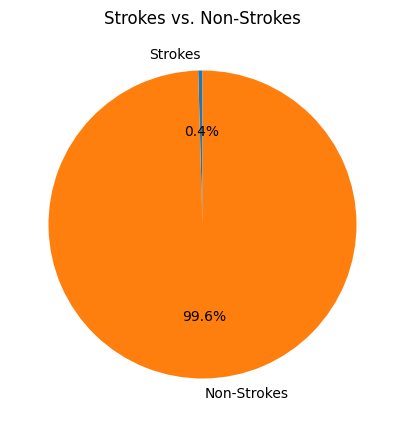

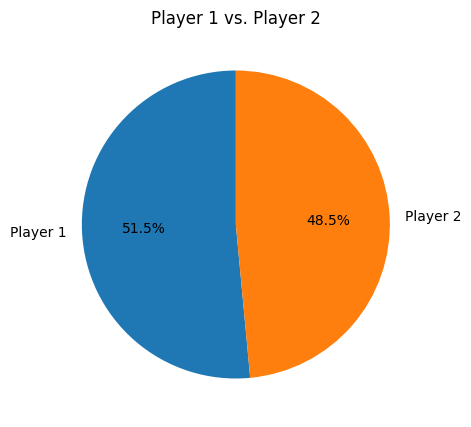

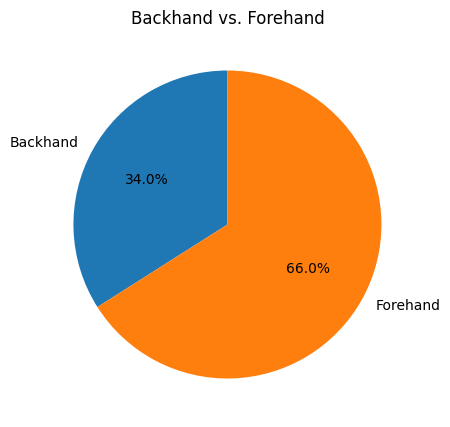

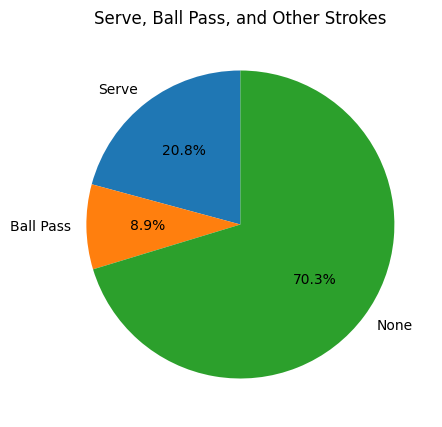

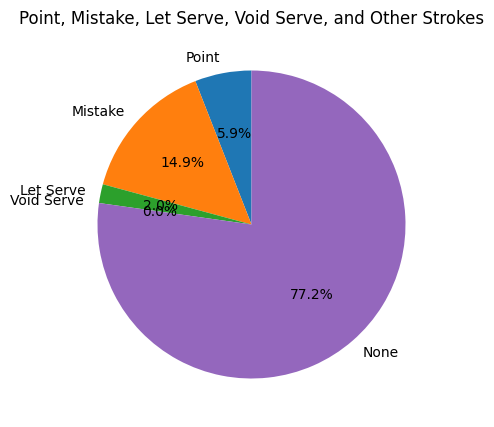

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/orsqi.xml:
strokes: 232
Player 1: 122
Player 2: 110
Serve: 47
Ball pass: 15
Point: 11
Mistake: 42
Let serve: 0
Void serve: 0
Forehand: 91
Backhand: 141
None: 27063


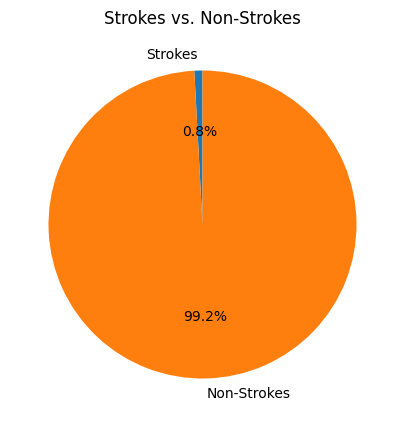

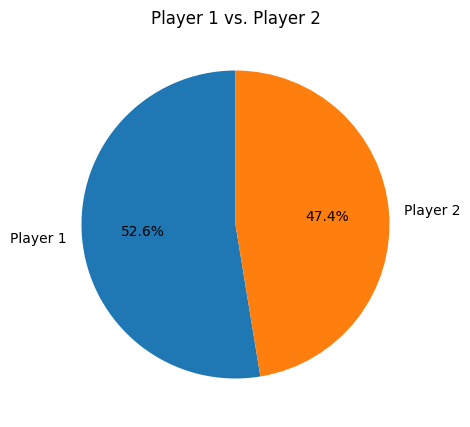

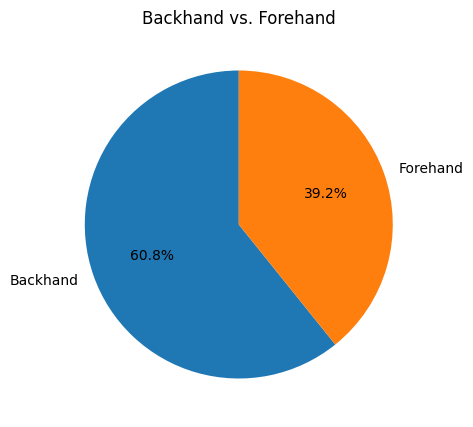

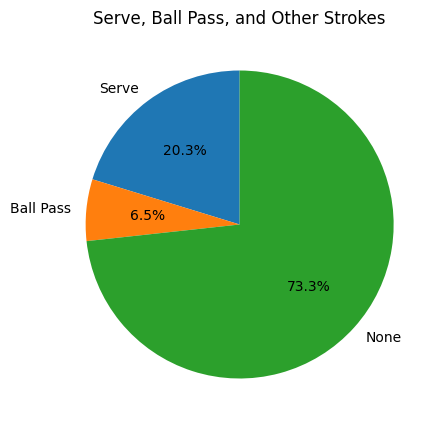

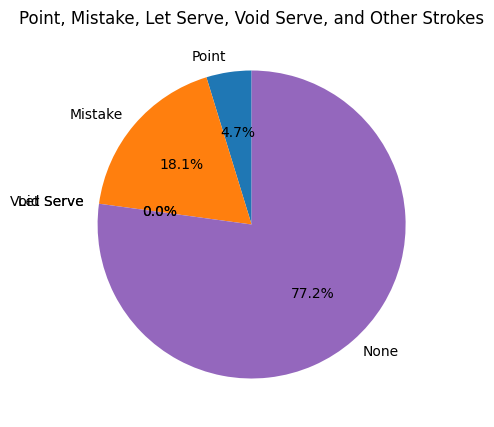

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/rhyqk.xml:
strokes: 458
Player 1: 234
Player 2: 224
Serve: 99
Ball pass: 47
Point: 17
Mistake: 81
Let serve: 2
Void serve: 0
Forehand: 178
Backhand: 279
None: 26973


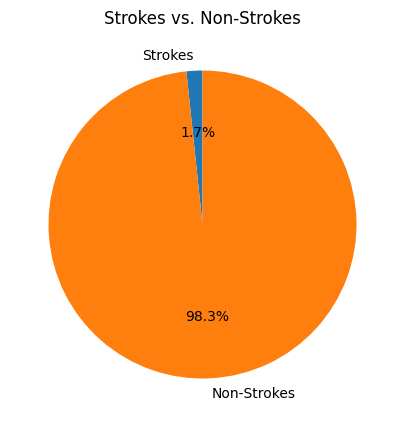

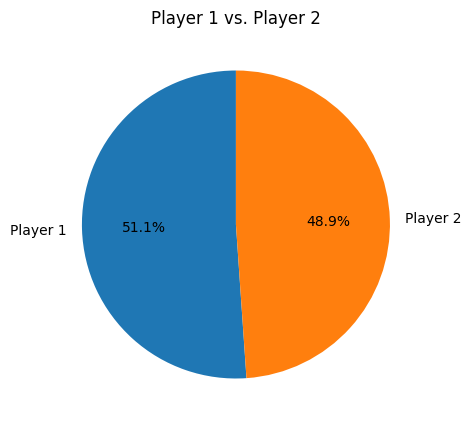

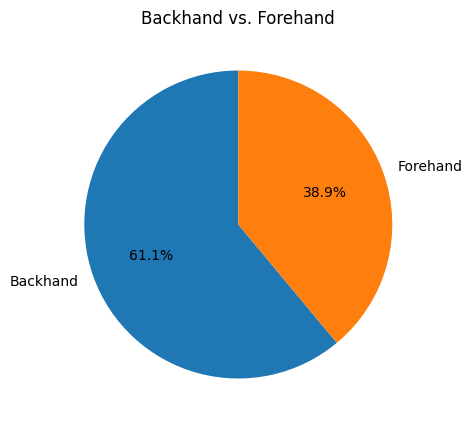

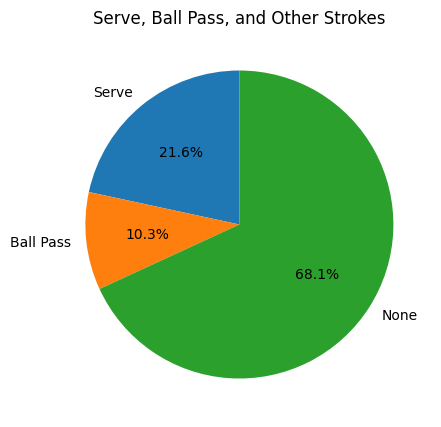

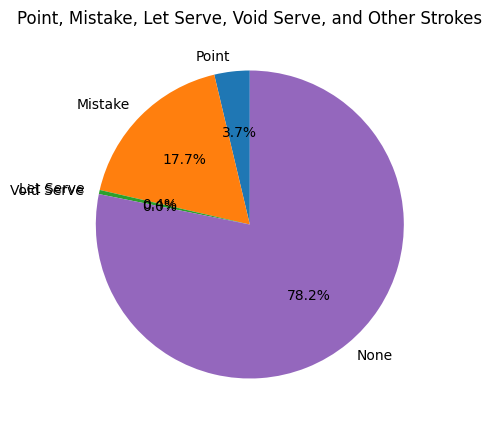

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/pciqj.xml:
strokes: 187
Player 1: 95
Player 2: 92
Serve: 43
Ball pass: 25
Point: 10
Mistake: 31
Let serve: 2
Void serve: 0
Forehand: 102
Backhand: 85
None: 15275


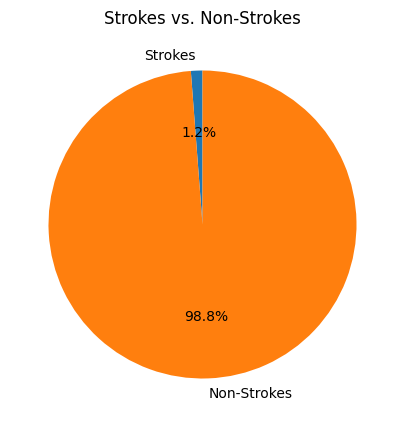

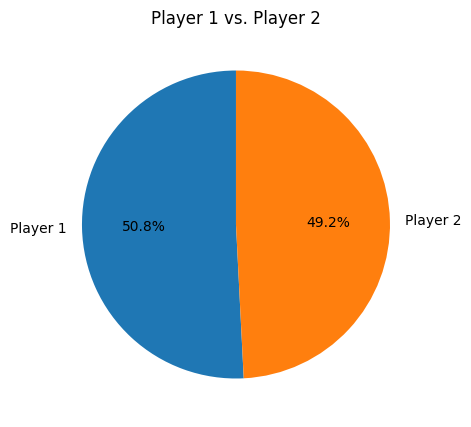

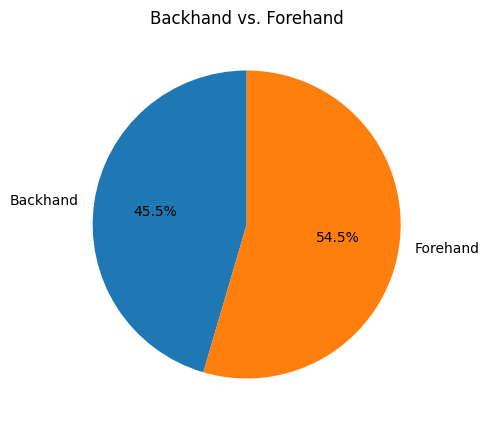

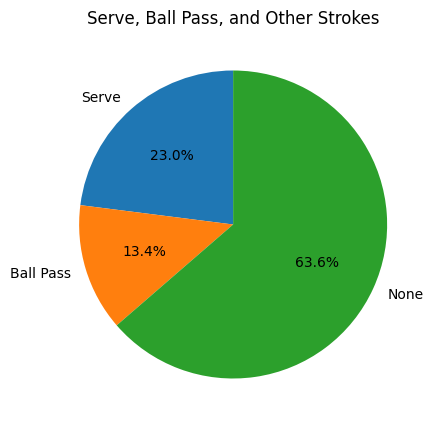

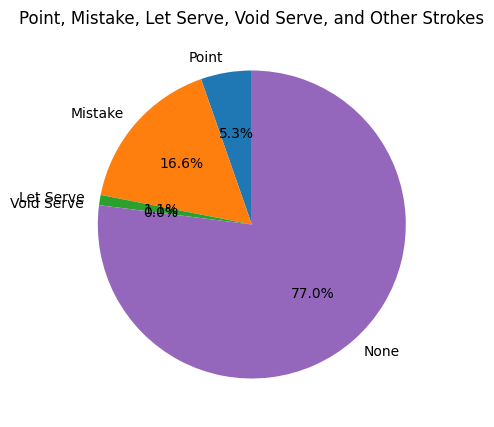

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/okfqy.xml:
strokes: 237
Player 1: 110
Player 2: 127
Serve: 51
Ball pass: 40
Point: 4
Mistake: 49
Let serve: 1
Void serve: 0
Forehand: 127
Backhand: 110
None: 21035


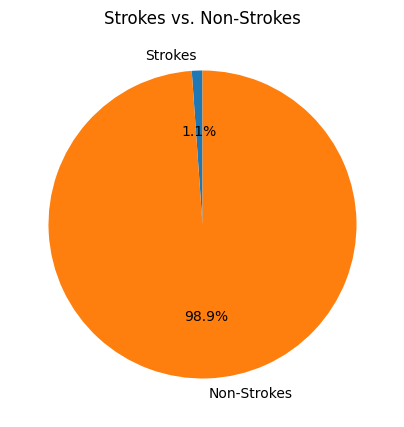

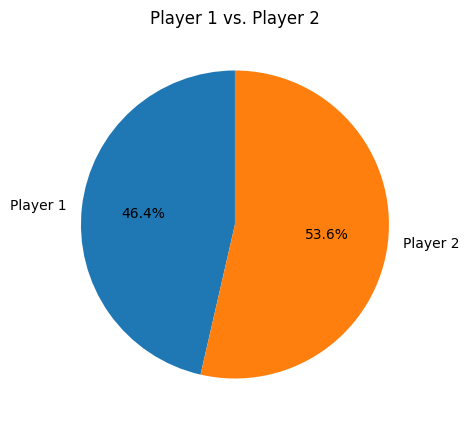

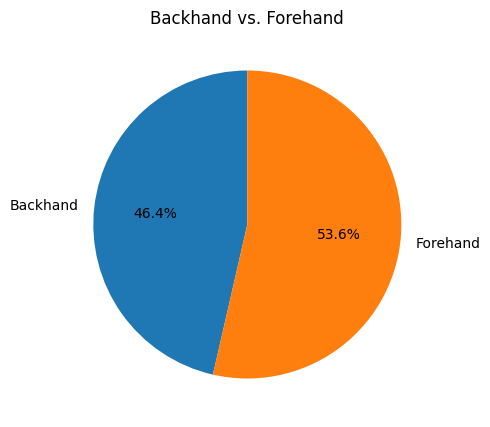

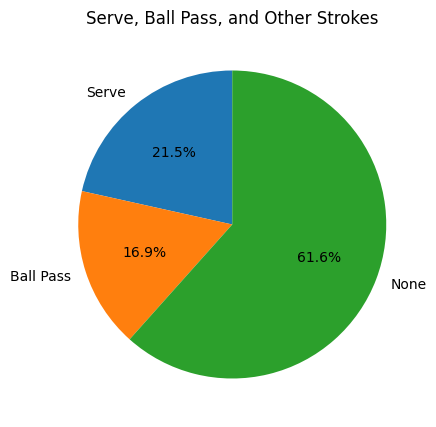

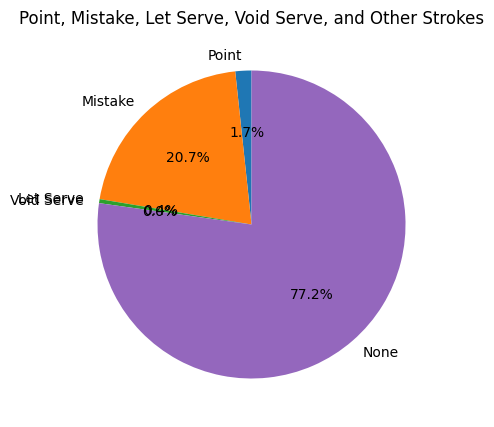

Stats for /content/drive/MyDrive/PRIM/dataset/outputs/kbfjj.xml:
strokes: 111
Player 1: 56
Player 2: 55
Serve: 18
Ball pass: 7
Point: 2
Mistake: 16
Let serve: 1
Void serve: 0
Forehand: 52
Backhand: 59
None: 7388


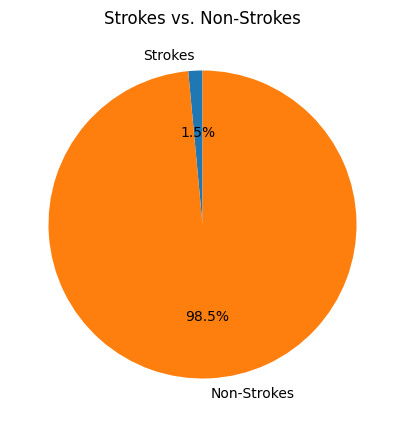

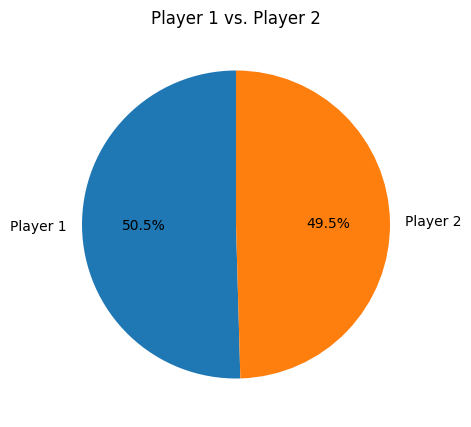

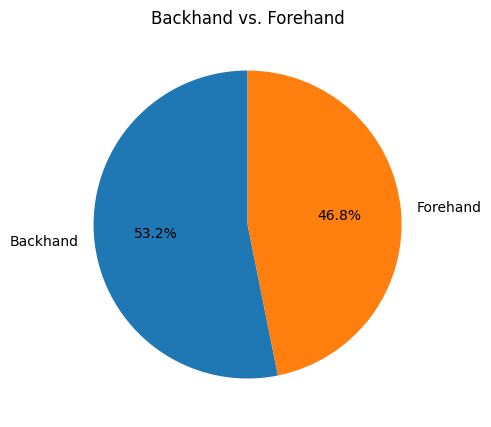

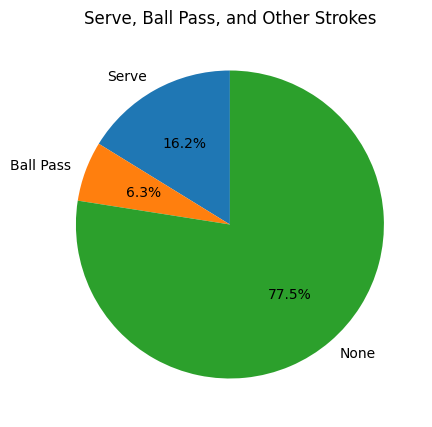

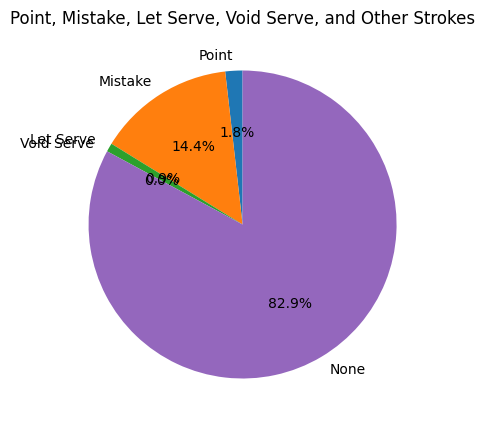

In [ ]:
output_folder = "/content/drive/MyDrive/PRIM/dataset/outputs"
output_files = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.xml')]
stats = analyze_output_files(output_files)

In [ ]:
def analyze_all_output_files(output_files):
    """
    Analyzes multiple output files and calculates statistics across all videos.

    Args:
        output_files: A list of paths to the XML output files.

    Returns:
        A dictionary containing the aggregated statistics across all videos.
    """

    all_stats = {
        "total_strokes": 0,
        "total_player_1_strokes": 0,
        "total_player_2_strokes": 0,
        "total_serve": 0,
        "total_ball_pass": 0,
        "total_point": 0,
        "total_mistake": 0,
        "total_let_serve": 0,
        "total_void_serve": 0,
        "total_forehand": 0,
        "total_backhand": 0,
        "total_none": 0,
        "total_frames": 0,
    }

    for output_file in output_files:
        xml = ET.parse(output_file)
        e = EventSequence(xml)
        number_of_frames = int(xml.find('meta/task/stop_frame').text)

        # Initialize video-specific stats
        stats = {
            "strokes": 0,
            "Player 1": 0,
            "Player 2": 0,
            "Serve": 0,
            "Ball pass": 0,
            "Point": 0,
            "Mistake": 0,
            "Let serve": 0,
            "Void serve": 0,
            "Forehand": 0,
            "Backhand": 0,
            "None": 0,
        }

        for i in range(number_of_frames):
            if "player 1" in e[i]:
                stats["strokes"] += 1
                stats["Player 1"] += 1
            if "player 2" in e[i]:
                stats["strokes"] += 1
                stats["Player 2"] += 1
            if "serve" in e[i]:
                stats["Serve"] += 1
            if "ball pass" in e[i]:
                stats["Ball pass"] += 1
            if "point" in e[i]:
                stats["Point"] += 1
            if "mistake" in e[i]:
                stats["Mistake"] += 1
            if "let serve" in e[i]:
                stats["Let serve"] += 1
            if "void serve" in e[i]:
                stats["Void serve"] += 1
            if "forehand" in e[i]:
                stats["Forehand"] += 1
            if "backhand" in e[i]:
                stats["Backhand"] += 1
            if not e[i]:
                stats["None"] += 1

        # Update all_stats with statistics from the current video
        all_stats["total_frames"] += number_of_frames
        all_stats["total_strokes"] += stats["strokes"]
        all_stats["total_player_1_strokes"] += stats["Player 1"]
        all_stats["total_player_2_strokes"] += stats["Player 2"]
        all_stats["total_serve"] += stats["Serve"]
        all_stats["total_ball_pass"] += stats["Ball pass"]
        all_stats["total_point"] += stats["Point"]
        all_stats["total_mistake"] += stats["Mistake"]
        all_stats["total_let_serve"] += stats["Let serve"]
        all_stats["total_void_serve"] += stats["Void serve"]
        all_stats["total_forehand"] += stats["Forehand"]
        all_stats["total_backhand"] += stats["Backhand"]
        all_stats["total_none"] += stats["None"]

    # Calculate overall percentages
    all_stats["percent_strokes"] = (all_stats["total_strokes"] / all_stats["total_frames"]) * 100
    all_stats["percent_player_1"] = (all_stats["total_player_1_strokes"] / all_stats["total_strokes"]) * 100
    all_stats["percent_player_2"] = (all_stats["total_player_2_strokes"] / all_stats["total_strokes"]) * 100
    all_stats["percent_serve"] = (all_stats["total_serve"] / all_stats["total_strokes"]) * 100
    all_stats["percent_ball_pass"] = (all_stats["total_ball_pass"] / all_stats["total_strokes"]) * 100
    all_stats["percent_point"] = (all_stats["total_point"] / all_stats["total_strokes"]) * 100
    all_stats["percent_mistake"] = (all_stats["total_mistake"] / all_stats["total_strokes"]) * 100
    all_stats["percent_let_serve"] = (all_stats["total_let_serve"] / all_stats["total_strokes"]) * 100
    all_stats["percent_void_serve"] = (all_stats["total_void_serve"] / all_stats["total_strokes"]) * 100
    all_stats["percent_forehand"] = (all_stats["total_forehand"] / all_stats["total_strokes"]) * 100
    all_stats["percent_backhand"] = (all_stats["total_backhand"] / all_stats["total_strokes"]) * 100
    all_stats["percent_none"] = (all_stats["total_none"] / all_stats["total_frames"]) * 100

    # Print aggregated statistics
    print("Aggregated Statistics Across All Videos:")
    for key, value in all_stats.items():
        print(f"{key}: {value:.2f}" if "%" in key else f"{key}: {value}")

    # Create and display overall pie charts
    labels = ['Strokes', 'Non-Strokes']
    sizes = [all_stats["total_strokes"], all_stats["total_frames"] - all_stats["total_strokes"]]
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title("Strokes vs. Non-Strokes")
    plt.show()

    labels = ['Player 1', 'Player 2']
    sizes = [all_stats["total_player_1_strokes"], all_stats["total_player_2_strokes"]]
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title("Player 1 vs. Player 2")
    plt.show()

    labels = ['Backhand', 'Forehand']
    sizes = [all_stats["total_backhand"], all_stats["total_forehand"]]
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title("Backhand vs. Forehand")
    plt.show()

    labels = ['Serve', 'Ball Pass', 'Other Strokes']
    other_strokes = all_stats["total_strokes"] - all_stats["total_serve"] - all_stats["total_ball_pass"]
    sizes = [all_stats["total_serve"], all_stats["total_ball_pass"], other_strokes]
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title("Serve, Ball Pass, and Other Strokes")
    plt.show()

    labels = ['Point', 'Mistake', 'Let Serve', 'Void Serve', 'Other Strokes']
    other_strokes = all_stats["total_strokes"] - all_stats["total_point"] - all_stats["total_mistake"] - \
                   all_stats["total_let_serve"] - all_stats["total_void_serve"]
    sizes = [all_stats["total_point"], all_stats["total_mistake"], all_stats["total_let_serve"],
             all_stats["total_void_serve"], other_strokes]
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title("Point, Mistake, Let Serve, Void Serve, and Other Strokes")
    plt.show()
    return all_stats


Aggregated Statistics Across All Videos:
total_strokes: 6800
total_player_1_strokes: 3398
total_player_2_strokes: 3402
total_serve: 1384
total_ball_pass: 663
total_point: 195
total_mistake: 1197
total_let_serve: 32
total_void_serve: 17
total_forehand: 3201
total_backhand: 3590
total_none: 643789
total_frames: 650587
percent_strokes: 1.0452099411761995
percent_player_1: 49.970588235294116
percent_player_2: 50.02941176470588
percent_serve: 20.352941176470587
percent_ball_pass: 9.75
percent_point: 2.8676470588235294
percent_mistake: 17.602941176470587
percent_let_serve: 0.4705882352941176
percent_void_serve: 0.25
percent_forehand: 47.07352941176471
percent_backhand: 52.794117647058826
percent_none: 98.95509747351238


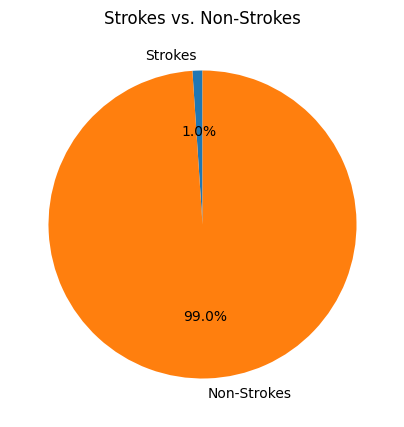

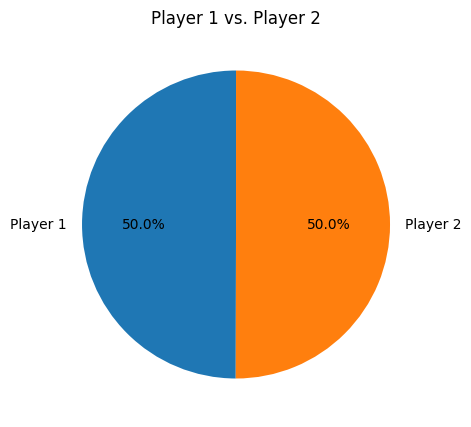

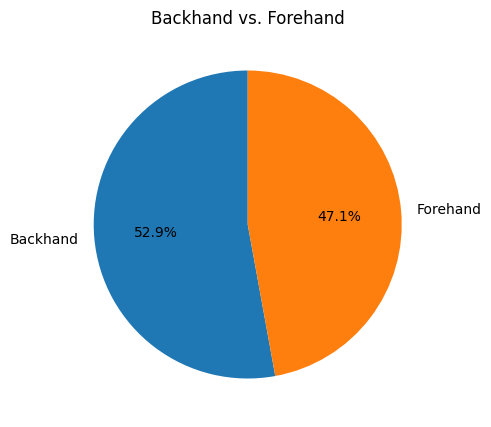

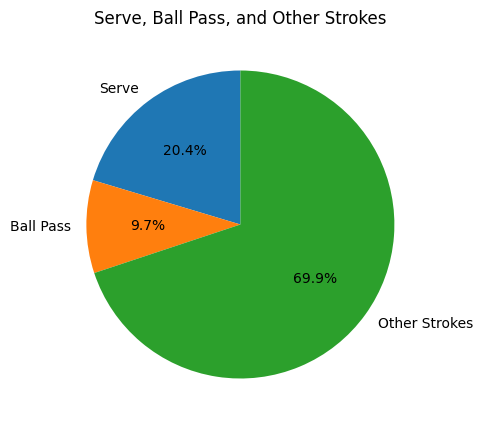

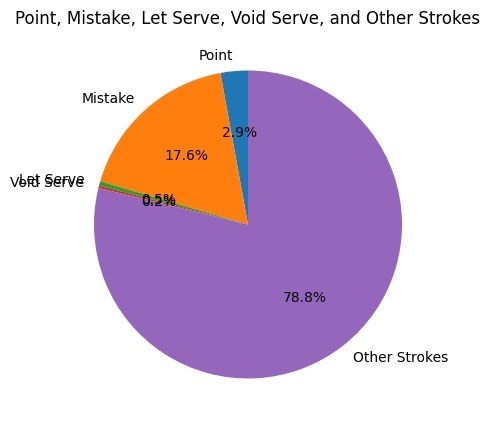

In [ ]:
stats = analyze_all_output_files(output_files)


1.   Player 1, Player 2 almost equally present makes sence
2.   There are almost always twice serve in comparison with Ball passes
3.   Mistakes are more predominent then Points
4.   Forehand / Backend distribution varies significantly from one case to the other
5.   Let serve and void serve are very **RARE EVENTS **
6.   Almost 99% of the output frames contains no tags



In [ ]:
def calculate_number_frames(output_file):
    """
    Analyzes a single output file and calculates frame intervals between
    consecutive strokes.

    Args:
        output_file: Path to the XML output file.

    Returns:
        A list containing the frame intervals between consecutive strokes
        for the given file.
    """

    frame_intervals = []
    xml = ET.parse(output_file)
    e = EventSequence(xml)
    number_of_frames = int(xml.find('meta/task/stop_frame').text)

    prev_stroke_frame = -1

    for i in range(number_of_frames):
        if any(x in e[i] for x in ("player 1", "player 2")):  # Check for any stroke
            if prev_stroke_frame != -1:
                frame_interval = i - prev_stroke_frame
                frame_intervals.append(frame_interval)
            prev_stroke_frame = i

    return frame_intervals


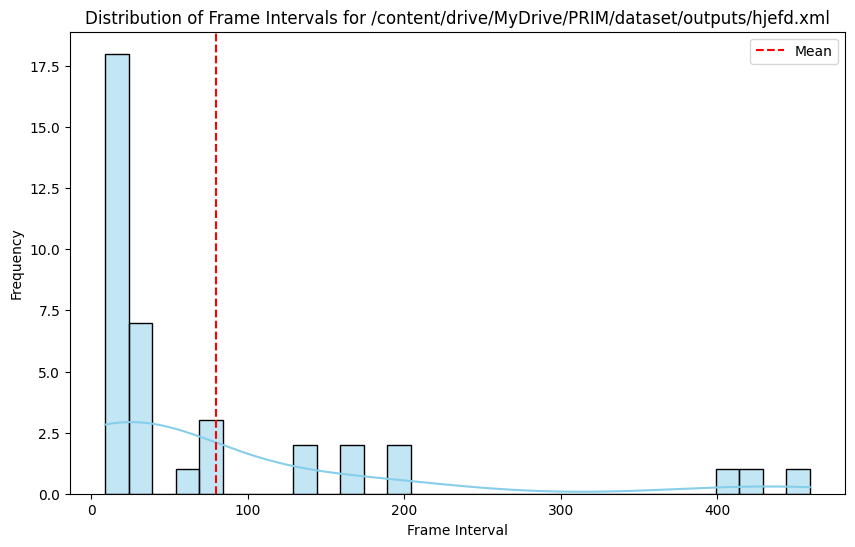

For /content/drive/MyDrive/PRIM/dataset/outputs/hjefd.xml:
Average Frame Interval: 79.68
Minimum Frame Interval: 9
Maximum Frame Interval: 459



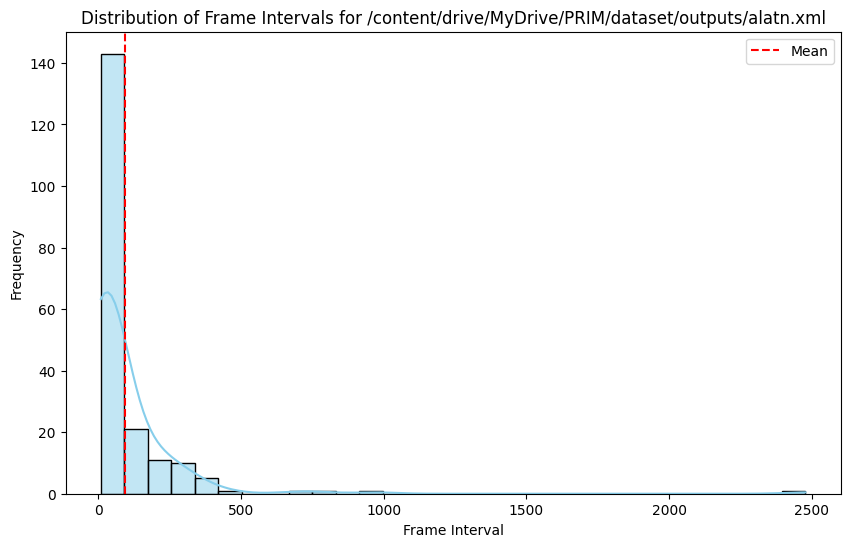

For /content/drive/MyDrive/PRIM/dataset/outputs/alatn.xml:
Average Frame Interval: 94.41
Minimum Frame Interval: 9
Maximum Frame Interval: 2478



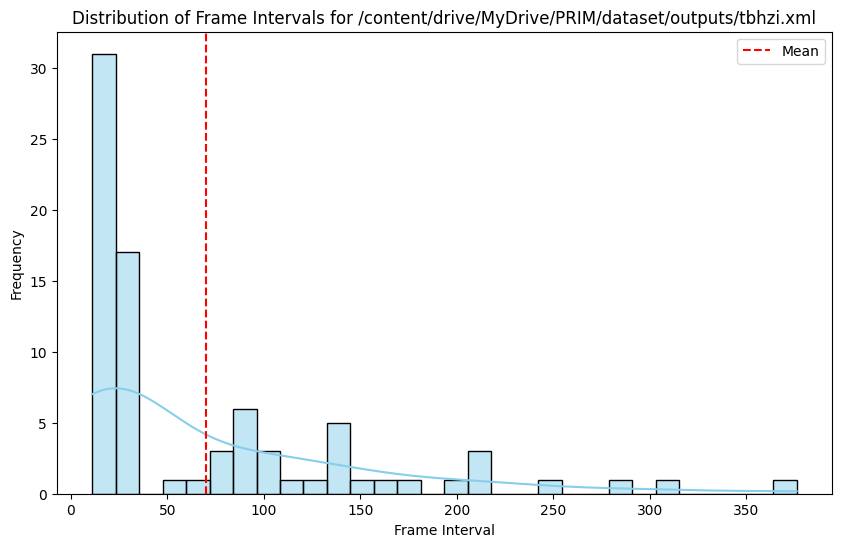

For /content/drive/MyDrive/PRIM/dataset/outputs/tbhzi.xml:
Average Frame Interval: 70.21
Minimum Frame Interval: 11
Maximum Frame Interval: 376



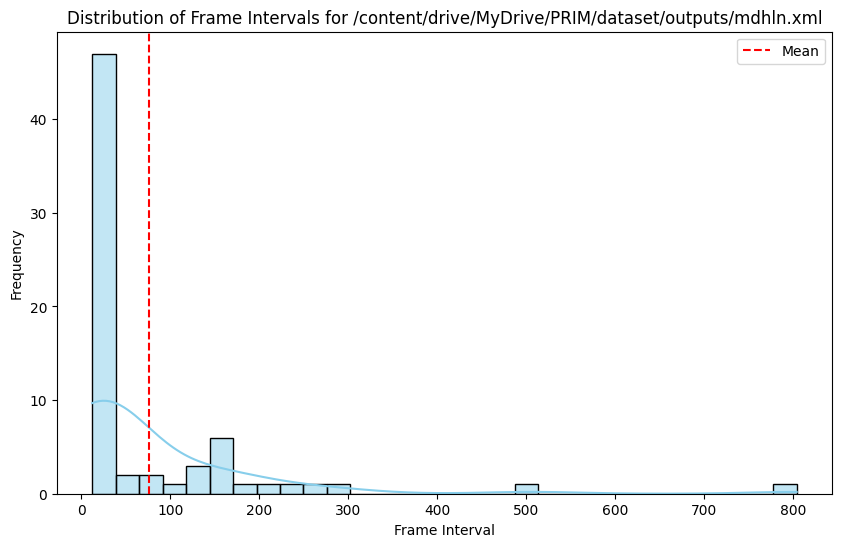

For /content/drive/MyDrive/PRIM/dataset/outputs/mdhln.xml:
Average Frame Interval: 75.88
Minimum Frame Interval: 12
Maximum Frame Interval: 804



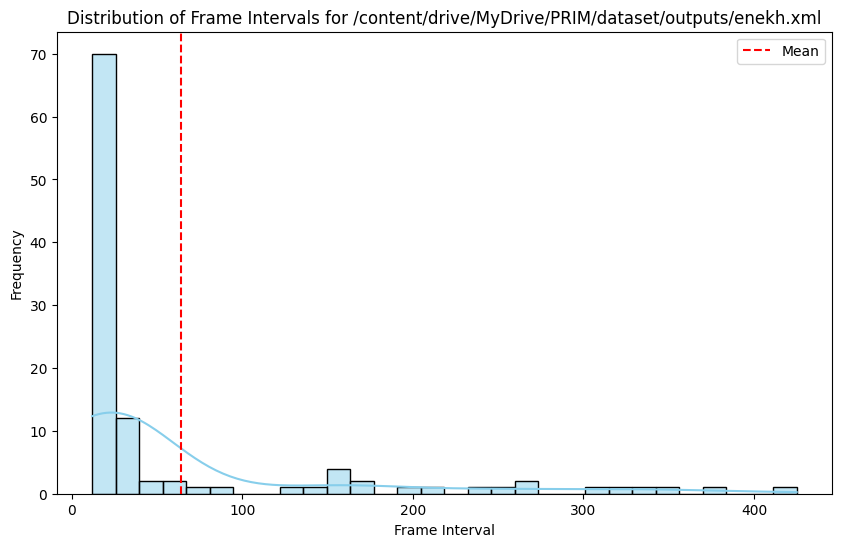

For /content/drive/MyDrive/PRIM/dataset/outputs/enekh.xml:
Average Frame Interval: 63.99
Minimum Frame Interval: 12
Maximum Frame Interval: 425



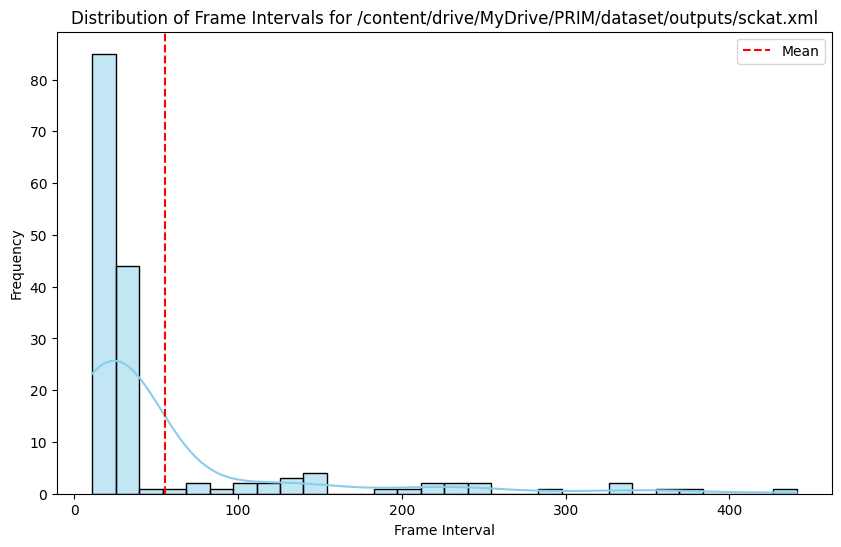

For /content/drive/MyDrive/PRIM/dataset/outputs/sckat.xml:
Average Frame Interval: 55.18
Minimum Frame Interval: 11
Maximum Frame Interval: 441



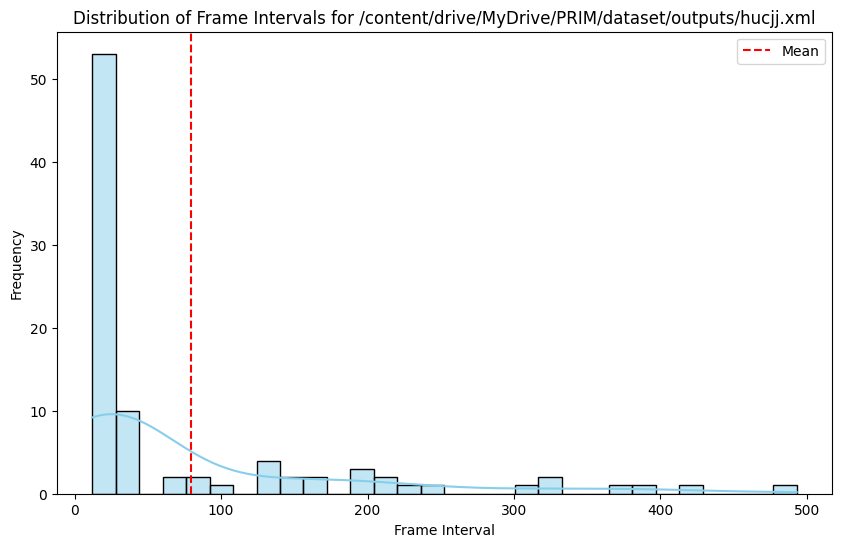

For /content/drive/MyDrive/PRIM/dataset/outputs/hucjj.xml:
Average Frame Interval: 79.47
Minimum Frame Interval: 12
Maximum Frame Interval: 493



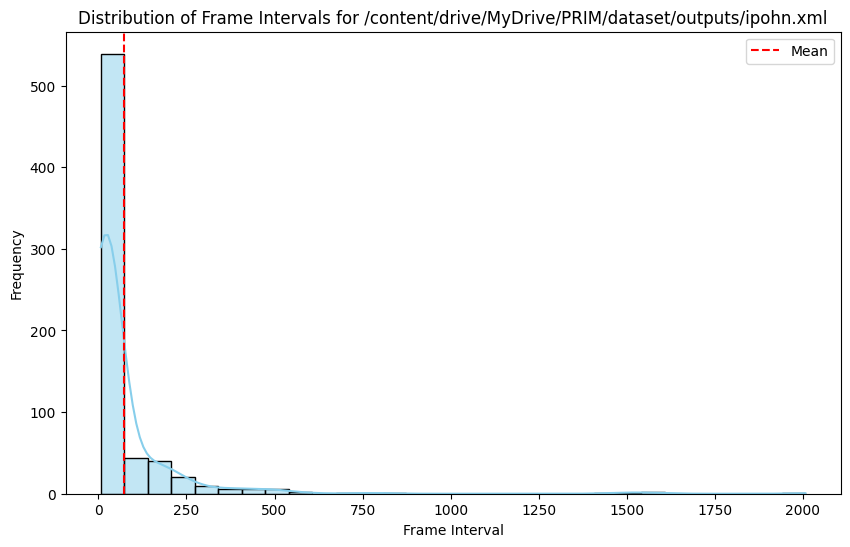

For /content/drive/MyDrive/PRIM/dataset/outputs/ipohn.xml:
Average Frame Interval: 71.84
Minimum Frame Interval: 7
Maximum Frame Interval: 2007



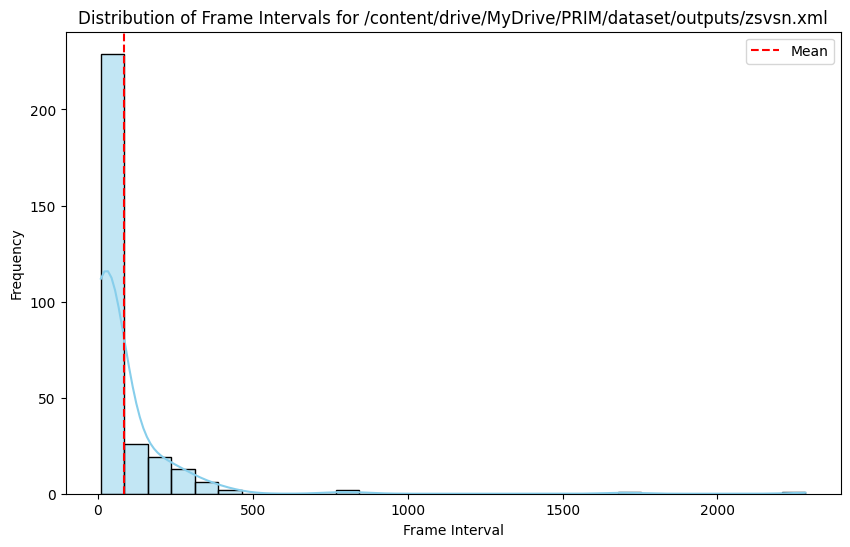

For /content/drive/MyDrive/PRIM/dataset/outputs/zsvsn.xml:
Average Frame Interval: 83.47
Minimum Frame Interval: 10
Maximum Frame Interval: 2284



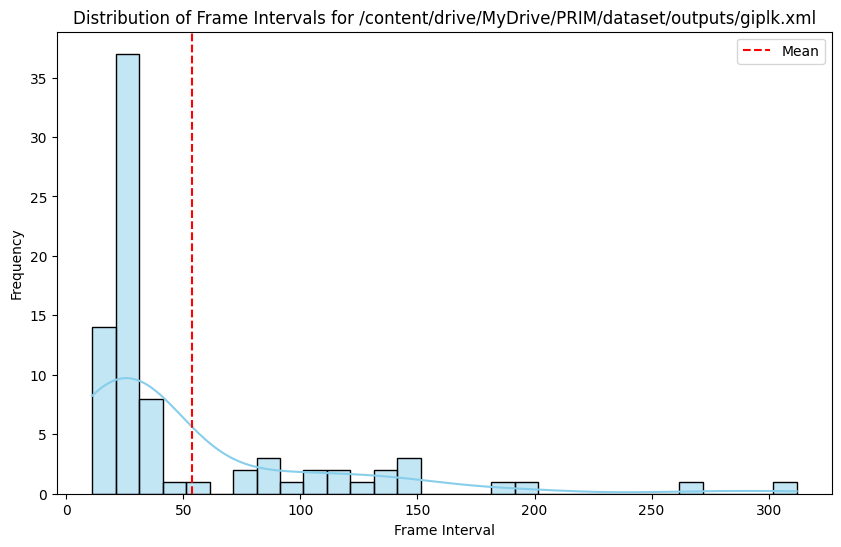

For /content/drive/MyDrive/PRIM/dataset/outputs/giplk.xml:
Average Frame Interval: 53.60
Minimum Frame Interval: 11
Maximum Frame Interval: 312



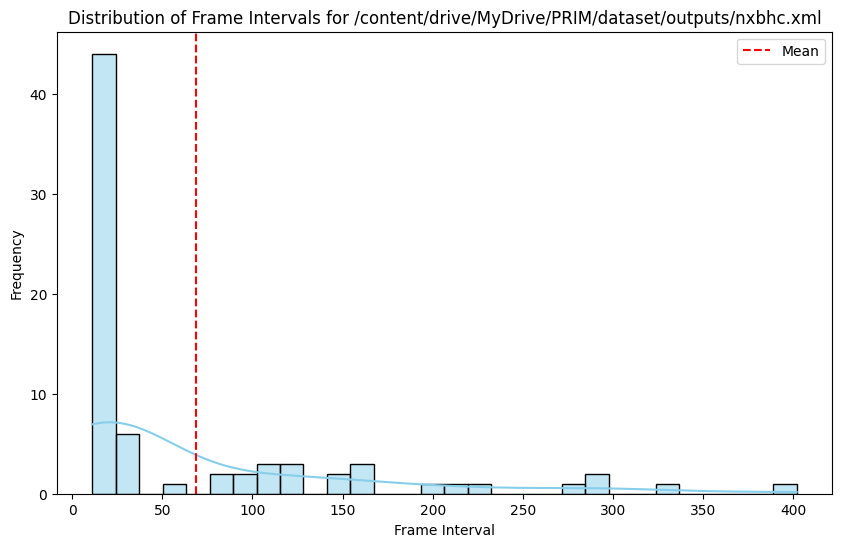

For /content/drive/MyDrive/PRIM/dataset/outputs/nxbhc.xml:
Average Frame Interval: 68.43
Minimum Frame Interval: 11
Maximum Frame Interval: 402



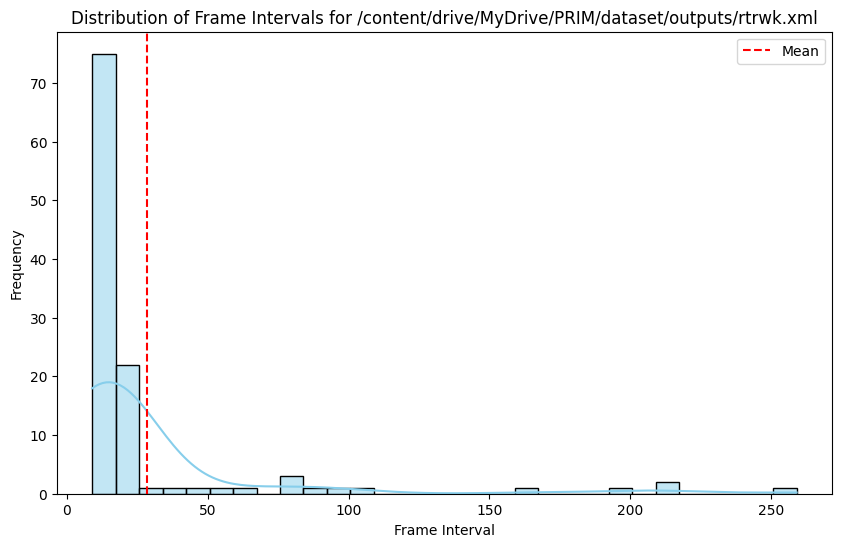

For /content/drive/MyDrive/PRIM/dataset/outputs/rtrwk.xml:
Average Frame Interval: 28.43
Minimum Frame Interval: 9
Maximum Frame Interval: 259



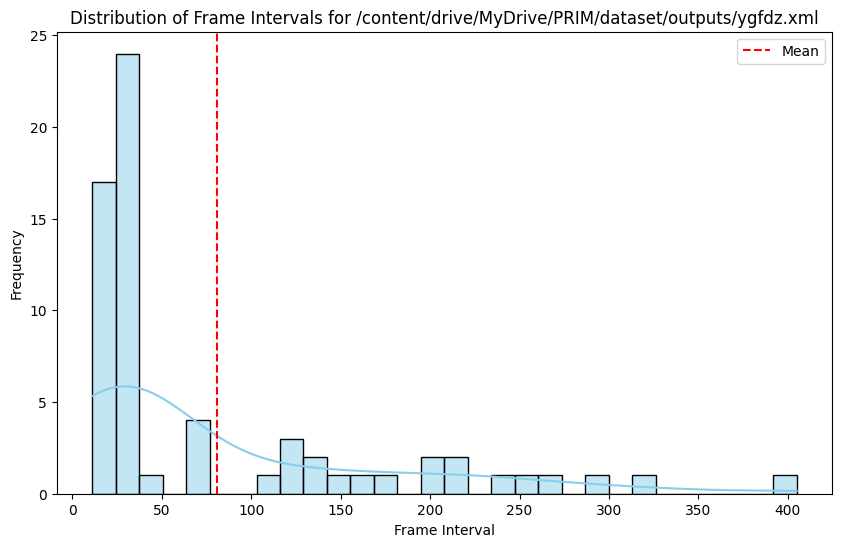

For /content/drive/MyDrive/PRIM/dataset/outputs/ygfdz.xml:
Average Frame Interval: 80.69
Minimum Frame Interval: 11
Maximum Frame Interval: 405



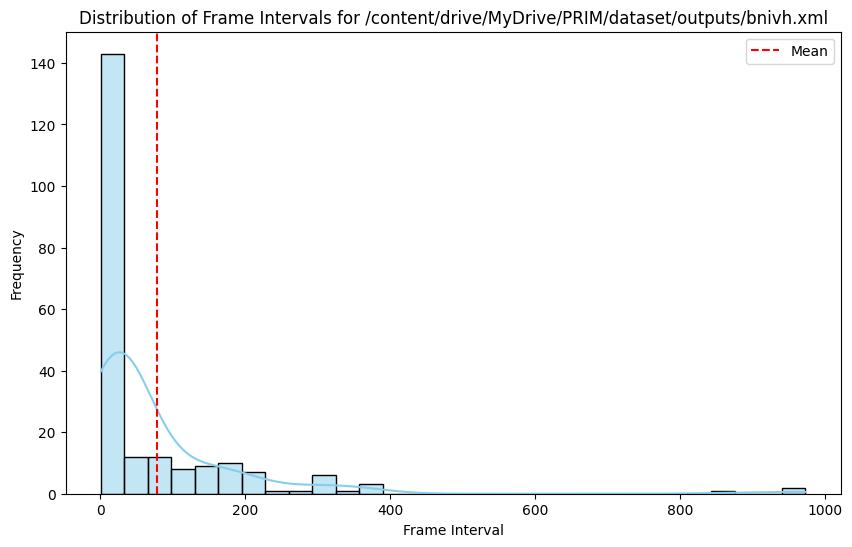

For /content/drive/MyDrive/PRIM/dataset/outputs/bnivh.xml:
Average Frame Interval: 77.84
Minimum Frame Interval: 1
Maximum Frame Interval: 973



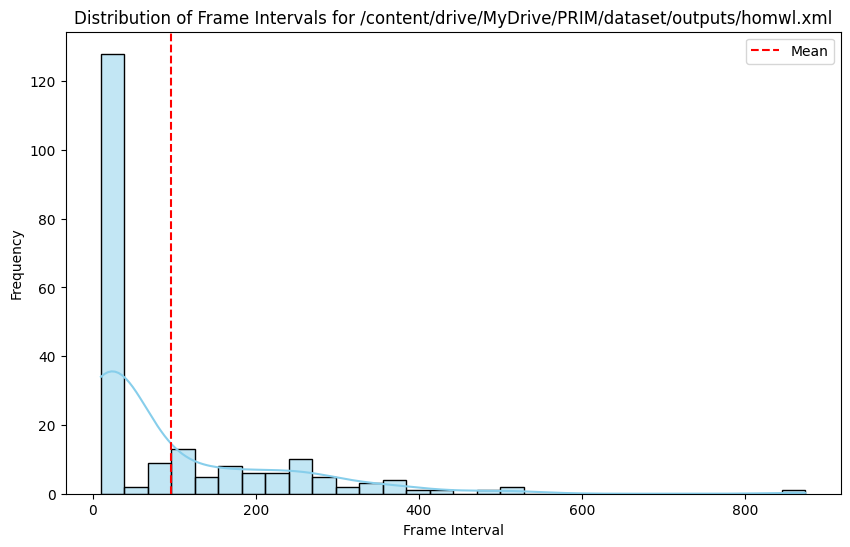

For /content/drive/MyDrive/PRIM/dataset/outputs/homwl.xml:
Average Frame Interval: 95.64
Minimum Frame Interval: 10
Maximum Frame Interval: 874



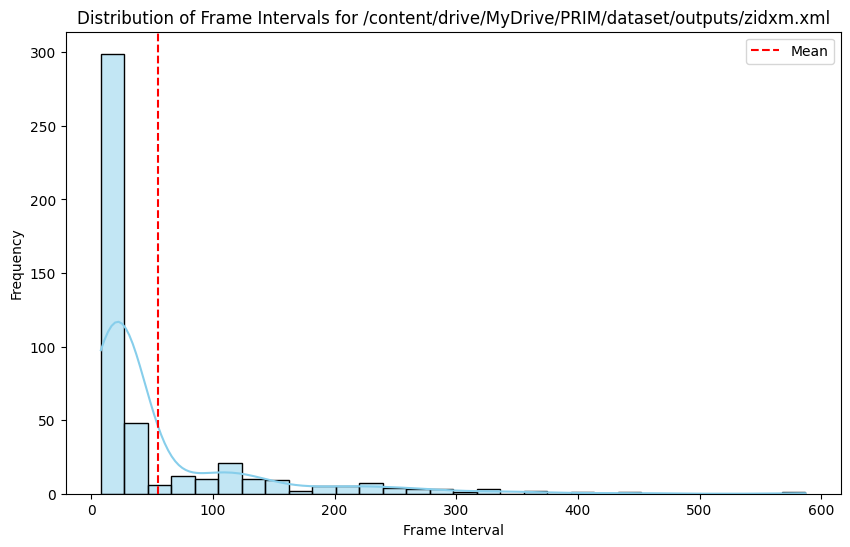

For /content/drive/MyDrive/PRIM/dataset/outputs/zidxm.xml:
Average Frame Interval: 55.12
Minimum Frame Interval: 8
Maximum Frame Interval: 587



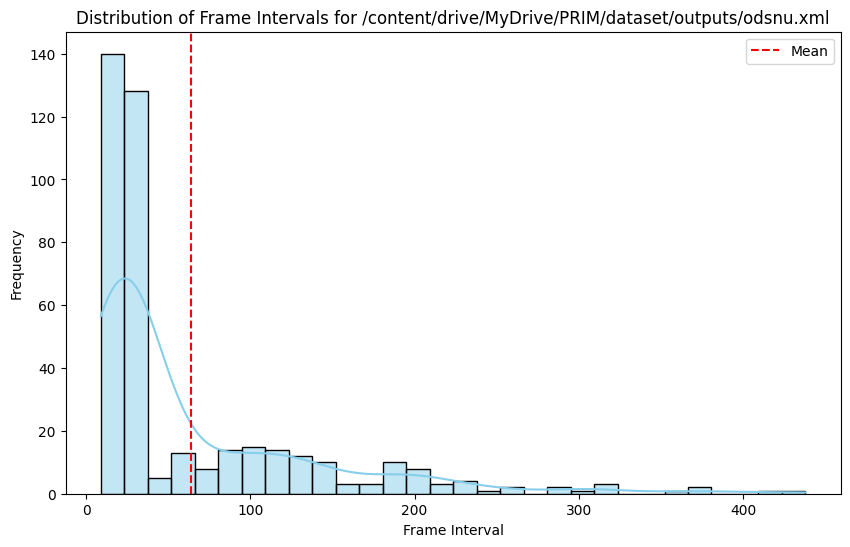

For /content/drive/MyDrive/PRIM/dataset/outputs/odsnu.xml:
Average Frame Interval: 63.59
Minimum Frame Interval: 9
Maximum Frame Interval: 438



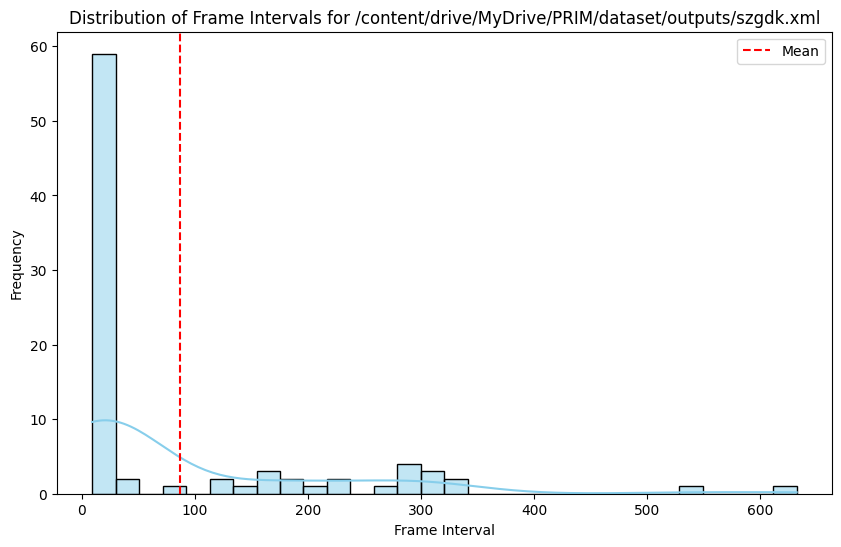

For /content/drive/MyDrive/PRIM/dataset/outputs/szgdk.xml:
Average Frame Interval: 86.32
Minimum Frame Interval: 9
Maximum Frame Interval: 632



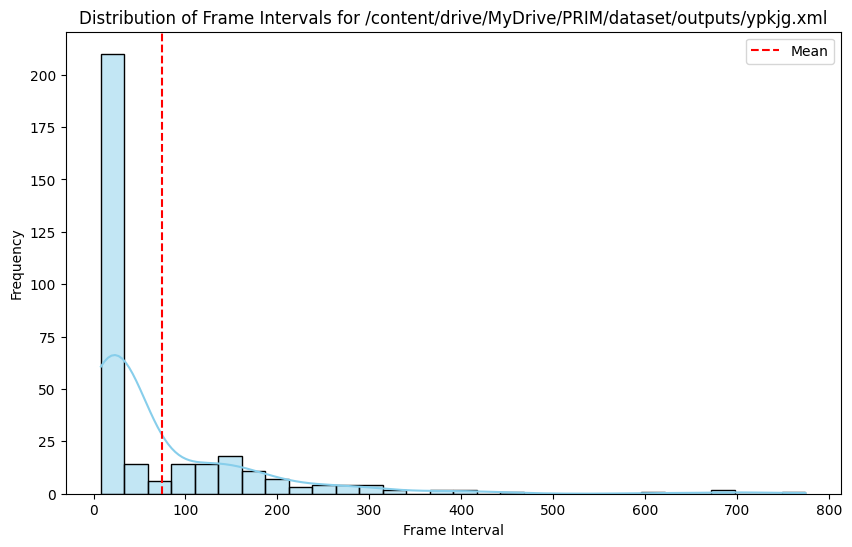

For /content/drive/MyDrive/PRIM/dataset/outputs/ypkjg.xml:
Average Frame Interval: 74.76
Minimum Frame Interval: 8
Maximum Frame Interval: 774



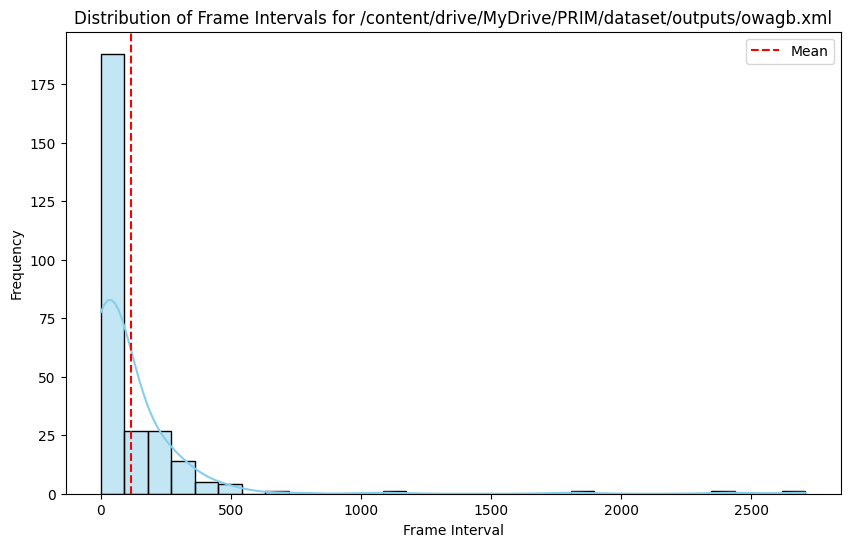

For /content/drive/MyDrive/PRIM/dataset/outputs/owagb.xml:
Average Frame Interval: 116.67
Minimum Frame Interval: 1
Maximum Frame Interval: 2708



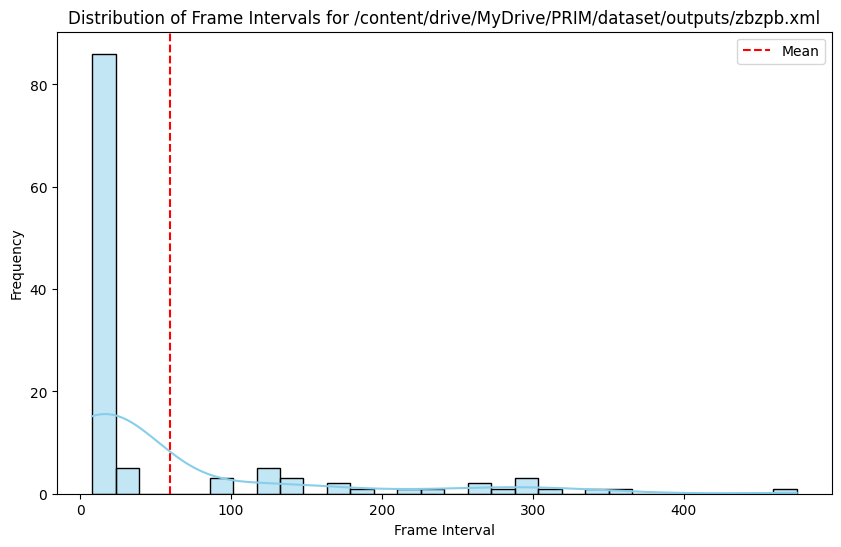

For /content/drive/MyDrive/PRIM/dataset/outputs/zbzpb.xml:
Average Frame Interval: 59.54
Minimum Frame Interval: 8
Maximum Frame Interval: 475



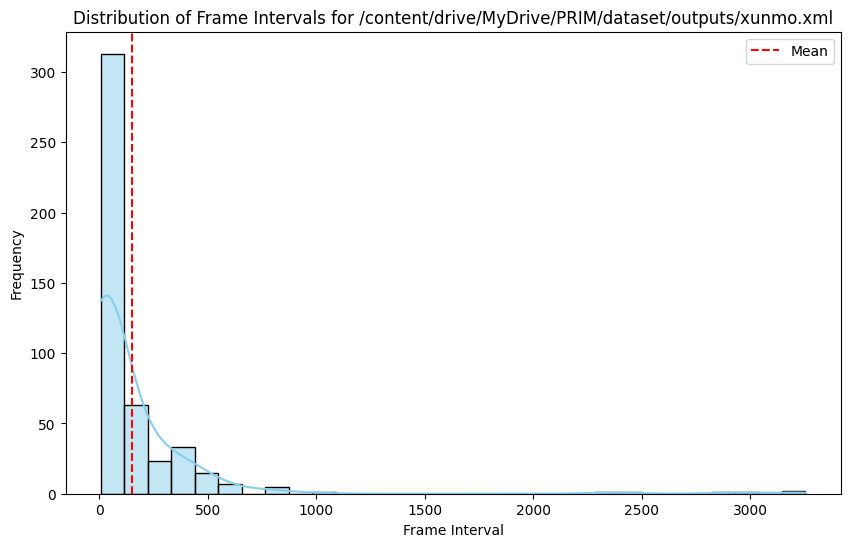

For /content/drive/MyDrive/PRIM/dataset/outputs/xunmo.xml:
Average Frame Interval: 150.99
Minimum Frame Interval: 8
Maximum Frame Interval: 3253



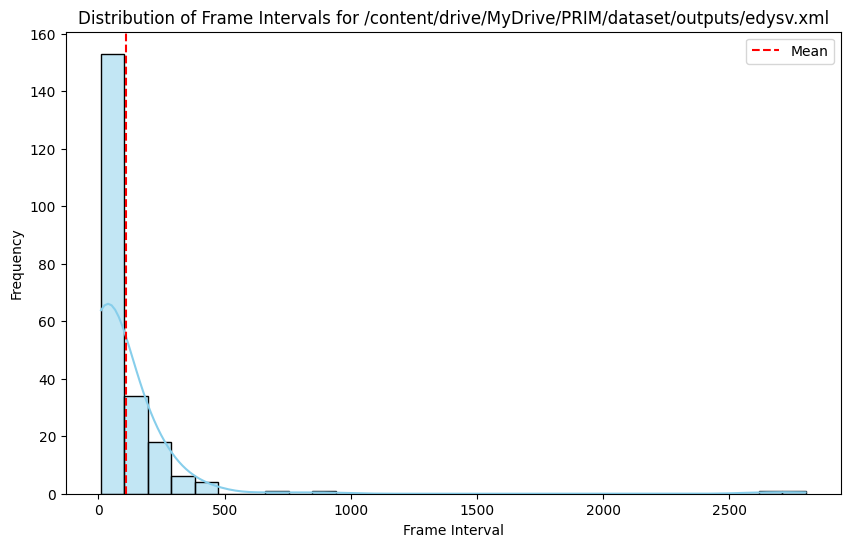

For /content/drive/MyDrive/PRIM/dataset/outputs/edysv.xml:
Average Frame Interval: 107.33
Minimum Frame Interval: 10
Maximum Frame Interval: 2802



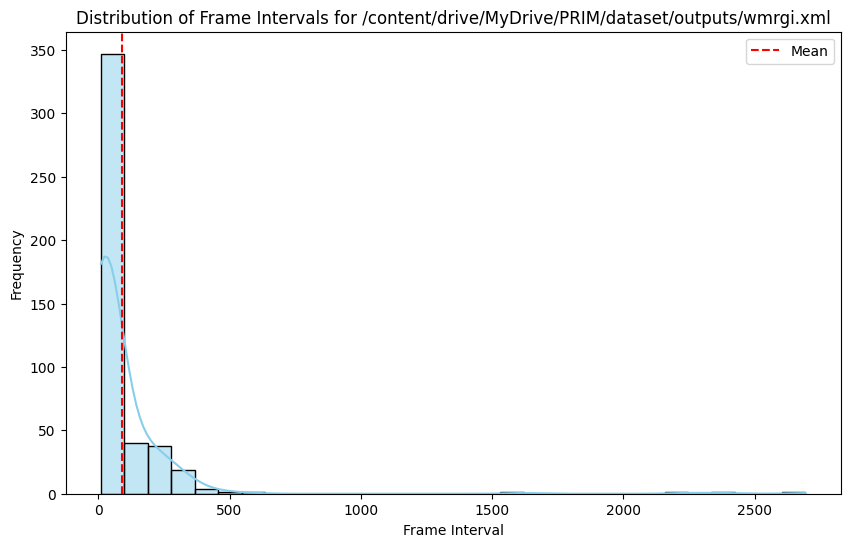

For /content/drive/MyDrive/PRIM/dataset/outputs/wmrgi.xml:
Average Frame Interval: 90.04
Minimum Frame Interval: 10
Maximum Frame Interval: 2694



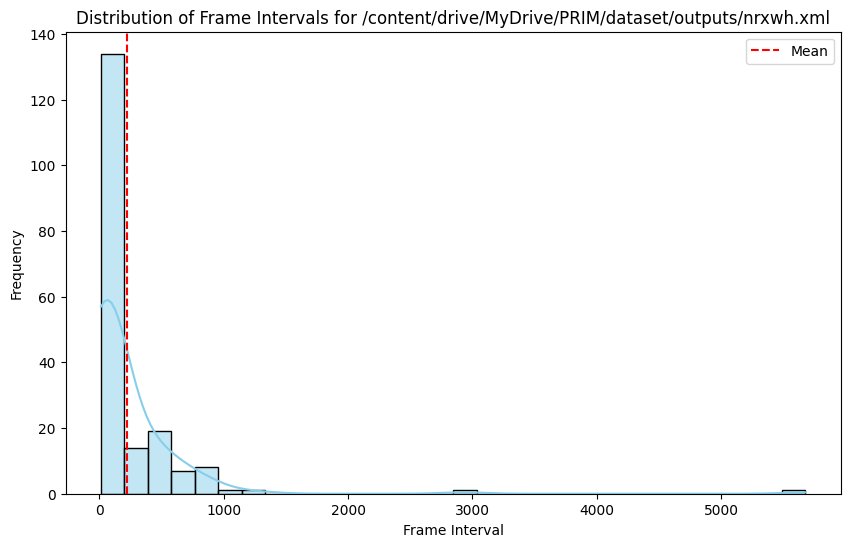

For /content/drive/MyDrive/PRIM/dataset/outputs/nrxwh.xml:
Average Frame Interval: 223.37
Minimum Frame Interval: 13
Maximum Frame Interval: 5677



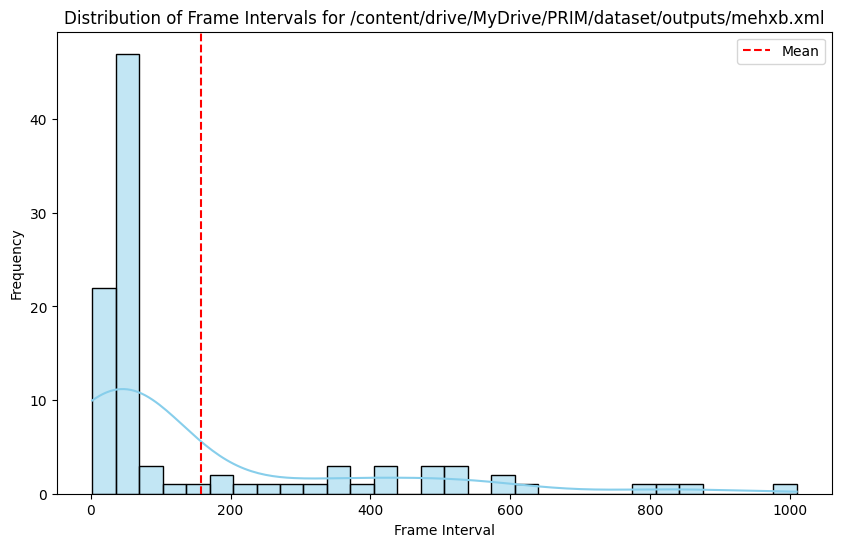

For /content/drive/MyDrive/PRIM/dataset/outputs/mehxb.xml:
Average Frame Interval: 158.14
Minimum Frame Interval: 2
Maximum Frame Interval: 1010



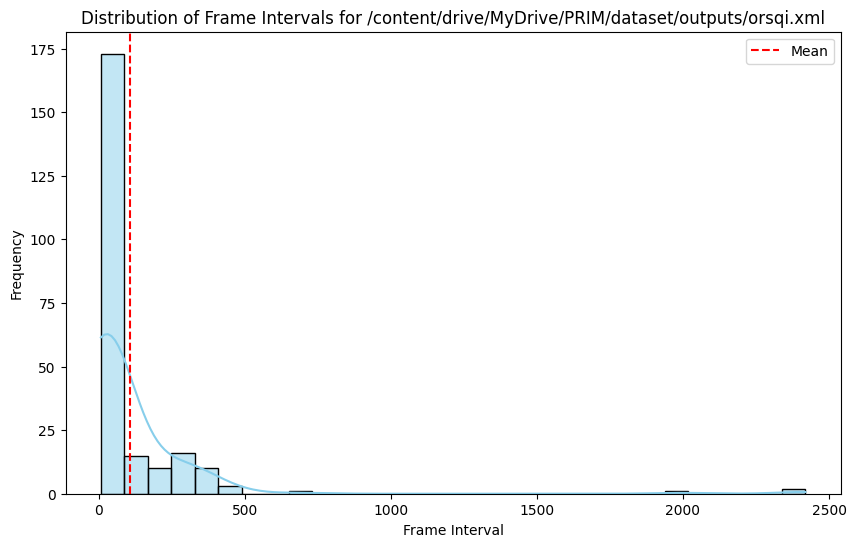

For /content/drive/MyDrive/PRIM/dataset/outputs/orsqi.xml:
Average Frame Interval: 107.60
Minimum Frame Interval: 8
Maximum Frame Interval: 2419



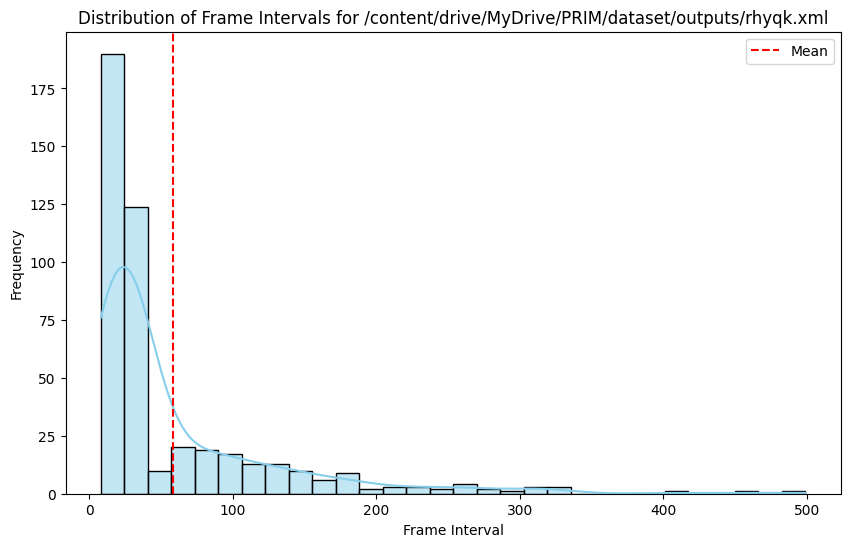

For /content/drive/MyDrive/PRIM/dataset/outputs/rhyqk.xml:
Average Frame Interval: 58.43
Minimum Frame Interval: 8
Maximum Frame Interval: 499



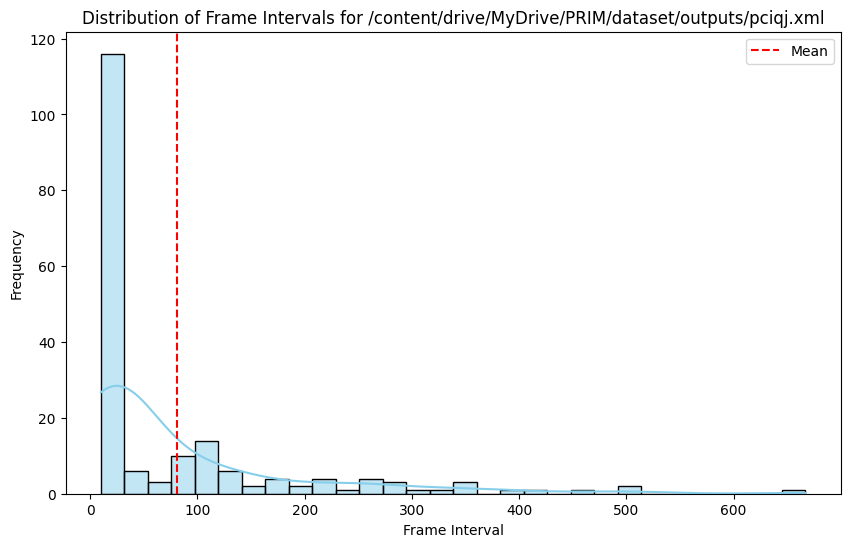

For /content/drive/MyDrive/PRIM/dataset/outputs/pciqj.xml:
Average Frame Interval: 80.75
Minimum Frame Interval: 10
Maximum Frame Interval: 667



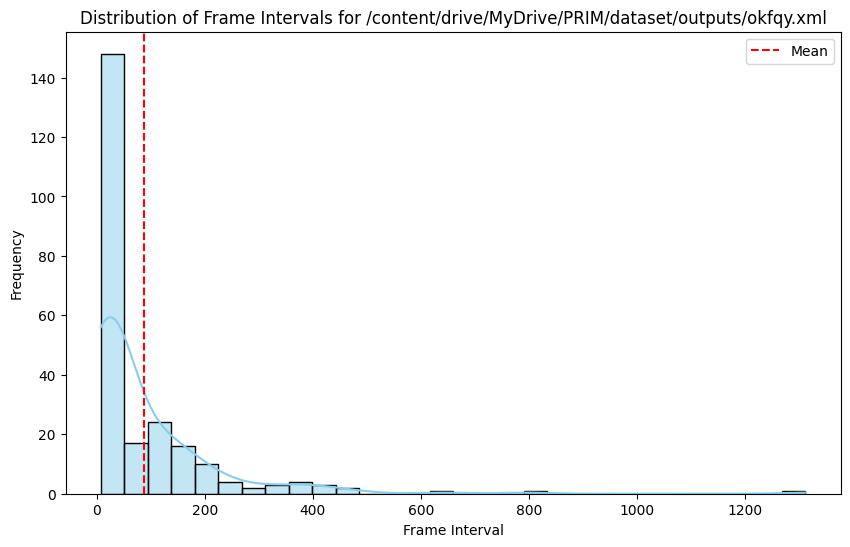

For /content/drive/MyDrive/PRIM/dataset/outputs/okfqy.xml:
Average Frame Interval: 87.03
Minimum Frame Interval: 8
Maximum Frame Interval: 1311



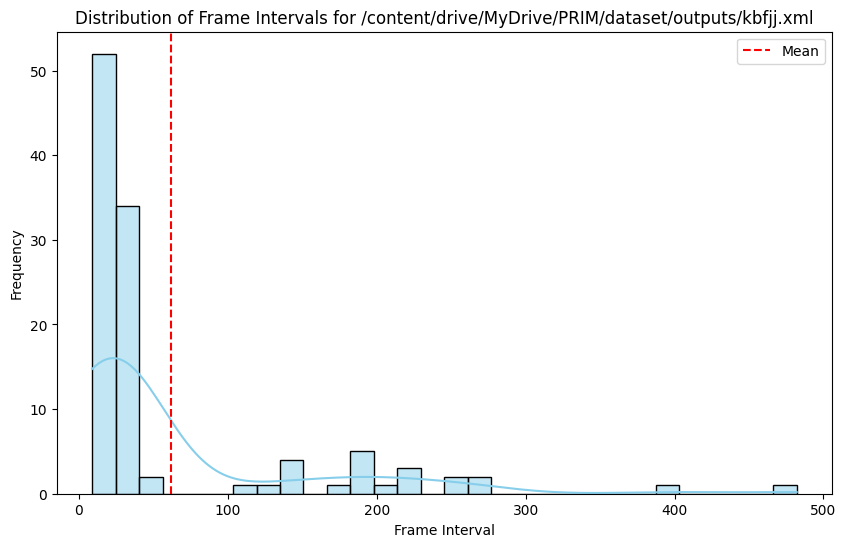

For /content/drive/MyDrive/PRIM/dataset/outputs/kbfjj.xml:
Average Frame Interval: 61.63
Minimum Frame Interval: 9
Maximum Frame Interval: 482



In [ ]:
import seaborn as sns
for output_file in output_files:
        frame_intervals = calculate_number_frames(output_file)

        # Plot histogram of frame intervals for the current file with improved style
        plt.figure(figsize=(10, 6))  # Increase figure size for better readability
        sns.histplot(frame_intervals, bins=30, kde=True, color='skyblue')
        plt.xlabel("Frame Interval")
        plt.ylabel("Frequency")
        plt.title(f"Distribution of Frame Intervals for {output_file}")

        # Add a vertical line for the mean
        plt.axvline(x=sum(frame_intervals) / len(frame_intervals), color='r', linestyle='--', label='Mean')

        plt.legend()
        plt.show()

        # Calculate and print frame interval statistics for the current file
        if frame_intervals:
            avg_interval = sum(frame_intervals) / len(frame_intervals)
            min_interval = min(frame_intervals)
            max_interval = max(frame_intervals)
            print(f"For {output_file}:")
            print(f"Average Frame Interval: {avg_interval:.2f}")
            print(f"Minimum Frame Interval: {min_interval}")
            print(f"Maximum Frame Interval: {max_interval}")
            print()
